# Pronostic de pannes sur des données IoT

Pronostic de pannes à partir du jeu de données généré par https://github.com/Azure/AI-PredictiveMaintenance/blob/master/src/Notebooks/DataGeneration.ipynb. Proposition de solution à base de machine learning avec un objectif de niveau de confiance élevé.

In [1]:
# Affichage plus large du notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# Importations de modules et classes
import os, sys, random, pickle
print("Python: ", sys.version)
import numpy as np
print("NumPy: ", np.__version__)
import joblib
print("Joblib: ", joblib.__version__)
import pandas as pd
print("Pandas: ", pd.__version__)
import sklearn as sk
print("Scikit-learn: ", sk.__version__)
import tensorflow as tf
print("TensorFlow: ", tf.__version__)

from typing import List, Set, Tuple
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from tensorflow import keras
print("Keras: ", keras.__version__)

# Matplotlib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print("Matplotlib: ", matplotlib.__version__)

Python:  3.7.6 (default, Jan 19 2020, 22:34:52) 
[GCC 9.2.1 20200117]
NumPy:  1.18.1
Joblib:  0.14.1
Pandas:  1.0.1
Scikit-learn:  0.22.1
TensorFlow:  2.1.0
Keras:  2.2.4-tf
Matplotlib:  3.1.3


# Importation des données

L'exécution du notebook DataGeneration.ipynb génère un jeu de données (télémétrie et maintenance) dans le dossier `~/data`. La fonction `load_data` charge ces données dans deux DataFrames: `tele` et `logs`.

In [3]:
data_path = Path.home().joinpath('data')
data_dir = str(data_path)
%ls $data_dir
# %ls $data_dir/logs -lh
# %ls $data_dir/telemetry -lh

logs/  telemetry/


In [4]:
def load_data(d_path: Path = data_path) -> (pd.DataFrame, pd.DataFrame):
    """Retourne le couple (logs, tele) où le second est une concaténation
    de l'ensemble des fichiers parquet présents dans le répertoire d_path/telemetry.
    """
    return pd.read_parquet(d_path.joinpath('logs/logs.parquet'), engine='fastparquet'), pd.concat(
        pd.read_parquet(parquet_file, engine='fastparquet')
        for parquet_file in d_path.glob('telemetry/*.parquet'))

In [5]:
%%time
logs, tele = load_data()
#display(tele.head(1))
#display(tele.head(1))

CPU times: user 9.16 s, sys: 608 ms, total: 9.77 s
Wall time: 9.78 s


# Prétraitement des données

* suppression des colonnes inutiles
* normalisation des données de télémétrie dans [0, 1]
* conversion des textes en int et float
* création d'une liste "parc des machines"
* prise en compte des "secondes écoulées où la machine est en fonctionnement" (`seconds_ON`)
* lissage des données de télémétrie (prise en compte des temps OFF et des allumages)
* (régression et "dérivées": fausses pistes)
* lissage par moyenne

In [6]:
# Nombre de machines
n_machines = len(tele["machineID"].unique())
# n_machines

In [7]:
def trim_tele(tele: pd.DataFrame = tele) -> pd.DataFrame:
    "Enlève les colonnes 'ambient_temperature' et 'ambient_pressure'"
    return tele.drop(["ambient_temperature", "ambient_pressure"], axis=1)

def trim_logs(logs: pd.DataFrame = logs) -> pd.DataFrame:
    "Enlève la colonne 'level'"
    return logs.drop("level", axis=1)

In [8]:
%%time
tele_trim = trim_tele(tele)
logs_trim = trim_logs(logs)
#display(tele_trim.head(1))
#display(logs_trim.head(1))

CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 177 ms


In [9]:
def normalize_tele(tele: pd.DataFrame = tele) -> pd.DataFrame:
    "Retourne un pd.DataFrame de télémétrie avec des données ramenées entre 0 et 1."
    df = tele.copy()
    # Mise à zéro des vitesses négatives, qui sont des artefacts venant du bruit.
    df.loc[df['speed'] < 0, 'speed'] = 0
    df[['speed', 'temperature', 'pressure']] = minmax_scale(df[['speed', 'temperature', 'pressure']])
    return df

In [10]:
%%time
tele_norm = normalize_tele(tele_trim)
#display(tele_norm.head(1))

CPU times: user 3.11 s, sys: 472 ms, total: 3.58 s
Wall time: 3.6 s


In [11]:
# Il y a probablement une fonction prédéfinie pour cela.
# L'argument est un TimedeltaIndex, car convertir en secondes un DatetimeIndex n'a pas vraiment de sens.
def timedeltaIndex_to_seconds(t: pd.TimedeltaIndex) -> int:
    "Retourne le nombre de secondes correspondant au timedeltaIndex donné."
    return t.days * 3600 * 24 + t.seconds

def machineID_to_int(ID: str) -> int:
    "Retourne l'entier xxxx si le machineID est 'M_xxxx'."
    assert ID[:2] == 'M_'
    return int(ID[2:])

def code_to_int(code: str) -> int:
    "Retourne l'entier x si le code est 'Fx' ou 0 si le code est 'fixed'."
    return {"fixed": 0, "F1": 1, "F2": 2}[code]

def data_to_int(tele: pd.DataFrame, logs: pd.DataFrame) -> [pd.DataFrame, pd.DataFrame]:
    """Retourne une liste de deux pd.DataFrames [tele, logs], constitués uniquement
    de int ou float et indexés par le nombre de secondes écoulées depuis la première mesure.
    Ne modifie pas les arguments.
    """
    first = tele.index.min() # premier instant
    df = [tele.copy(), logs.copy()]
    for i in range(2):
        df[i]["machineID"] = df[i]["machineID"].apply(machineID_to_int)
        df[i]["seconds"] = timedeltaIndex_to_seconds(df[i].index - first)
    df[0].set_index("seconds", inplace=True)
    df[1].reset_index(inplace=True)
    df[1].drop('timestamp', axis=1, inplace=True)
    df[1]["code"] = df[1]["code"].apply(code_to_int)
    return df

In [12]:
%%time
tele_int, logs_int = data_to_int(tele_norm, logs_trim)
#display(tele_int.head(1))
#display(logs_int.head(1))

CPU times: user 5.88 s, sys: 208 ms, total: 6.09 s
Wall time: 6.11 s


In [13]:
def tombe_panne(logs: pd.DataFrame = logs_int) -> [Set[int], Set[int]]:
    """Renvoie une liste de deux ensembles: machines ayant connu une panne
    de type 1 ou 2 respectivement.
    """
    s = [set([]) for _ in range(2)]
    for i in logs.itertuples():
        if i.code != 0:
            s[i.code - 1].add(i.machineID)
    return s

In [14]:
mac_panne = tombe_panne(logs_int)
#print(mac_panne)
#mac_panne[0] & mac_panne[1]

In [15]:
def creer_parc(tele_int: pd.DataFrame = tele_int) -> pd.DataFrame:
    """Retourne le parc des machines, qui est une liste de pd.DataFrames indicés
    par secondes et triés chronologiquement.
    """
    n_machines = len(tele_int["machineID"].unique())
    return [tele_int[tele_int["machineID"] == i].sort_index() for i in range(n_machines)]

In [16]:
%%time
# Création du parc de machines:
parc = creer_parc(tele_int)
#display(parc[0].head(1))

CPU times: user 10.3 s, sys: 28 ms, total: 10.3 s
Wall time: 10.3 s


In [17]:
def lissage(tele_mac: pd.DataFrame, delai: int = 9) -> pd.DataFrame:
    """On retire les lignes correspondant à une machine à l'arrêt, et puisqu'il y
    a un certain délai après chaque allumage pour atteindre un régime à peu près
    stationnaire, on lisse les courbes correspondantes.
    La température n'a pas besoin d'être lissée.
    """
    histoire = delai + 20 # la télémétrie livre des données pendant 20 secondes après extinction
    df = tele_mac.copy()
    # Ajout des données retardées:
    df['shifted_speed_desired'] = df['speed_desired'].shift(periods=delai)
    df[['shifted_speed', 'shifted_pressure']] = df[['speed', 'pressure']].shift(periods=histoire)
    # Suppression des premières lignes car elles n'ont pas d'historique:
    df = df[histoire:]
    # Remplacement des données durant l'allumage par les données retardées:
    df["speed"] = df["speed"].where(df["shifted_speed_desired"] == 1000, other=df["shifted_speed"])
    df["pressure"] = df["pressure"].where(df["shifted_speed_desired"] == 1000, other=df["shifted_pressure"])
    # Suppression des lignes où la machine est éteinte:
    df.drop(df[df["speed_desired"] == 0].index, inplace=True)
    # Suppression des données retardées:
    df.drop(["speed_desired", "shifted_speed_desired", "shifted_speed", "shifted_pressure"], axis=1, inplace=True)
    # Réindexage: l'index n'est plus "seconds" (nombre de secondes écoulées depuis la première donnée
    # de l'ensemble du parc) mais un nouvel index correspondant au nombre de secondes écoulées où la
    # machine donnée est en fonctionnement:
    df.reset_index(inplace=True) # l'ancien index "seconds" et gardé dans une nouvelle colonne
    df.index.name="seconds_ON"
    return df

In [18]:
%%time
# Création du parc lissé:
parc_lisse = [lissage(tele_mac, delai=9) for tele_mac in parc]
#display(parc_lisse[0].head(1))

CPU times: user 6.42 s, sys: 120 ms, total: 6.54 s
Wall time: 6.54 s


# Visualisation

* visualisation du lissage
* graphe pour une machine donnée tout au long de la période, et visualisation des deux types de panne bien distincts

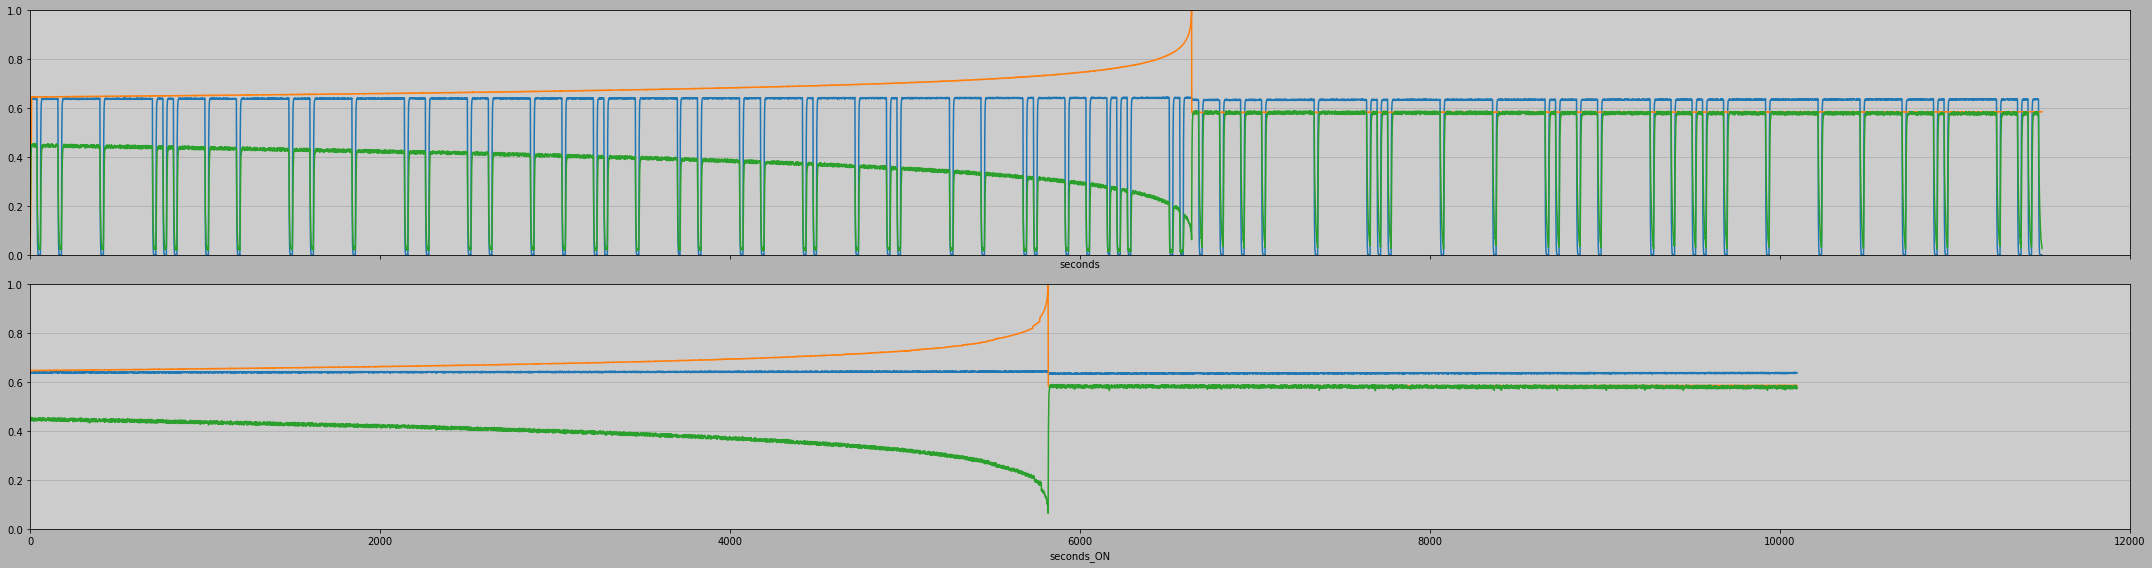

In [19]:
# Démonstration du lissage
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(30, 8))
ax0.plot(parc[1].reset_index()[["speed", "temperature", "pressure"]])
ax1.plot(parc_lisse[1][["speed", "temperature", "pressure"]])
ax0.set_xlim([0, 12_000])
ax0.set_ylim([0, 1])
ax0.grid(axis='y')
ax1.grid(axis='y')
ax0.set_xlabel("seconds")
ax1.set_xlabel("seconds_ON")
ax0.set_facecolor("0.8")
ax1.set_facecolor("0.8")
fig.set_facecolor("0.7")
plt.tight_layout()
plt.show()

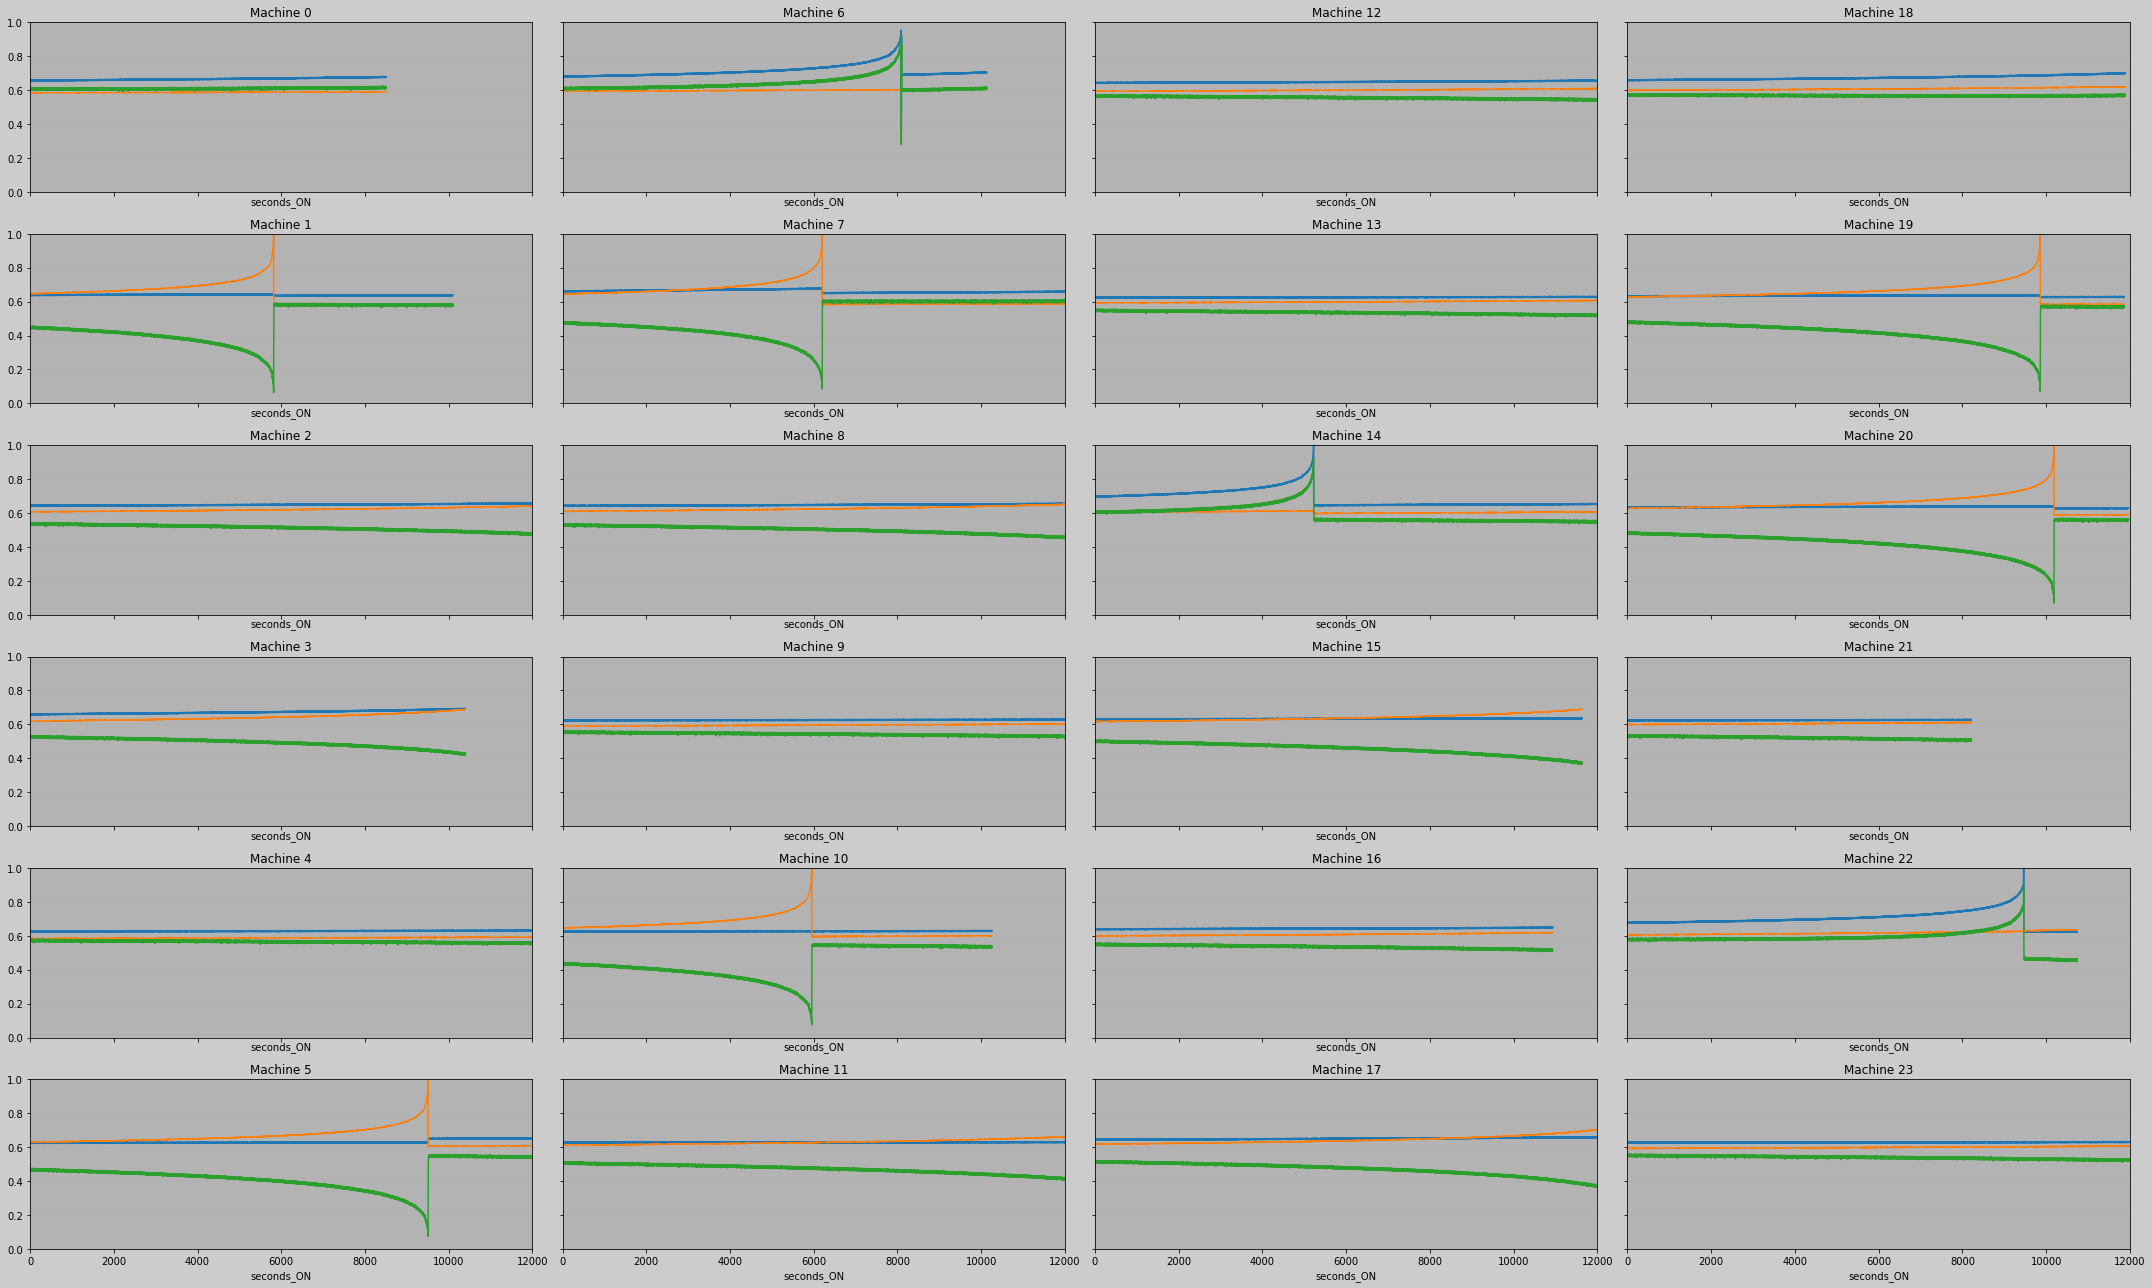

In [20]:
# Affichage des n premières machines sur col colonnes
n = 24
col = 4
m = 1 + (n - 1) // col
fig, axs = plt.subplots(m, col, sharex=True, sharey=True, figsize=(30, n * 3 / col))
#fig.suptitle('Vitesse, température et pression de différentes machines', fontsize=16)
# fig.figsize=(20, 15)
for i in range(n):
    j = (i % m, i // m)
    #ax = plt.gca()
    df = parc_lisse[i].reset_index(inplace=False)
    axs[j].plot(df[["speed", "temperature", "pressure"]])
    axs[j].set_title('Machine '+str(i))
    axs[j].set_xlabel("seconds_ON")
    axs[j].set_xlim([0, 12_000])
    axs[j].set_ylim([0, 1])
    axs[j].grid(axis='y')
    axs[j].figsize=(20, 5)
    axs[j].set_facecolor("0.7")
fig.set_facecolor("0.8")
plt.tight_layout()
plt.show()

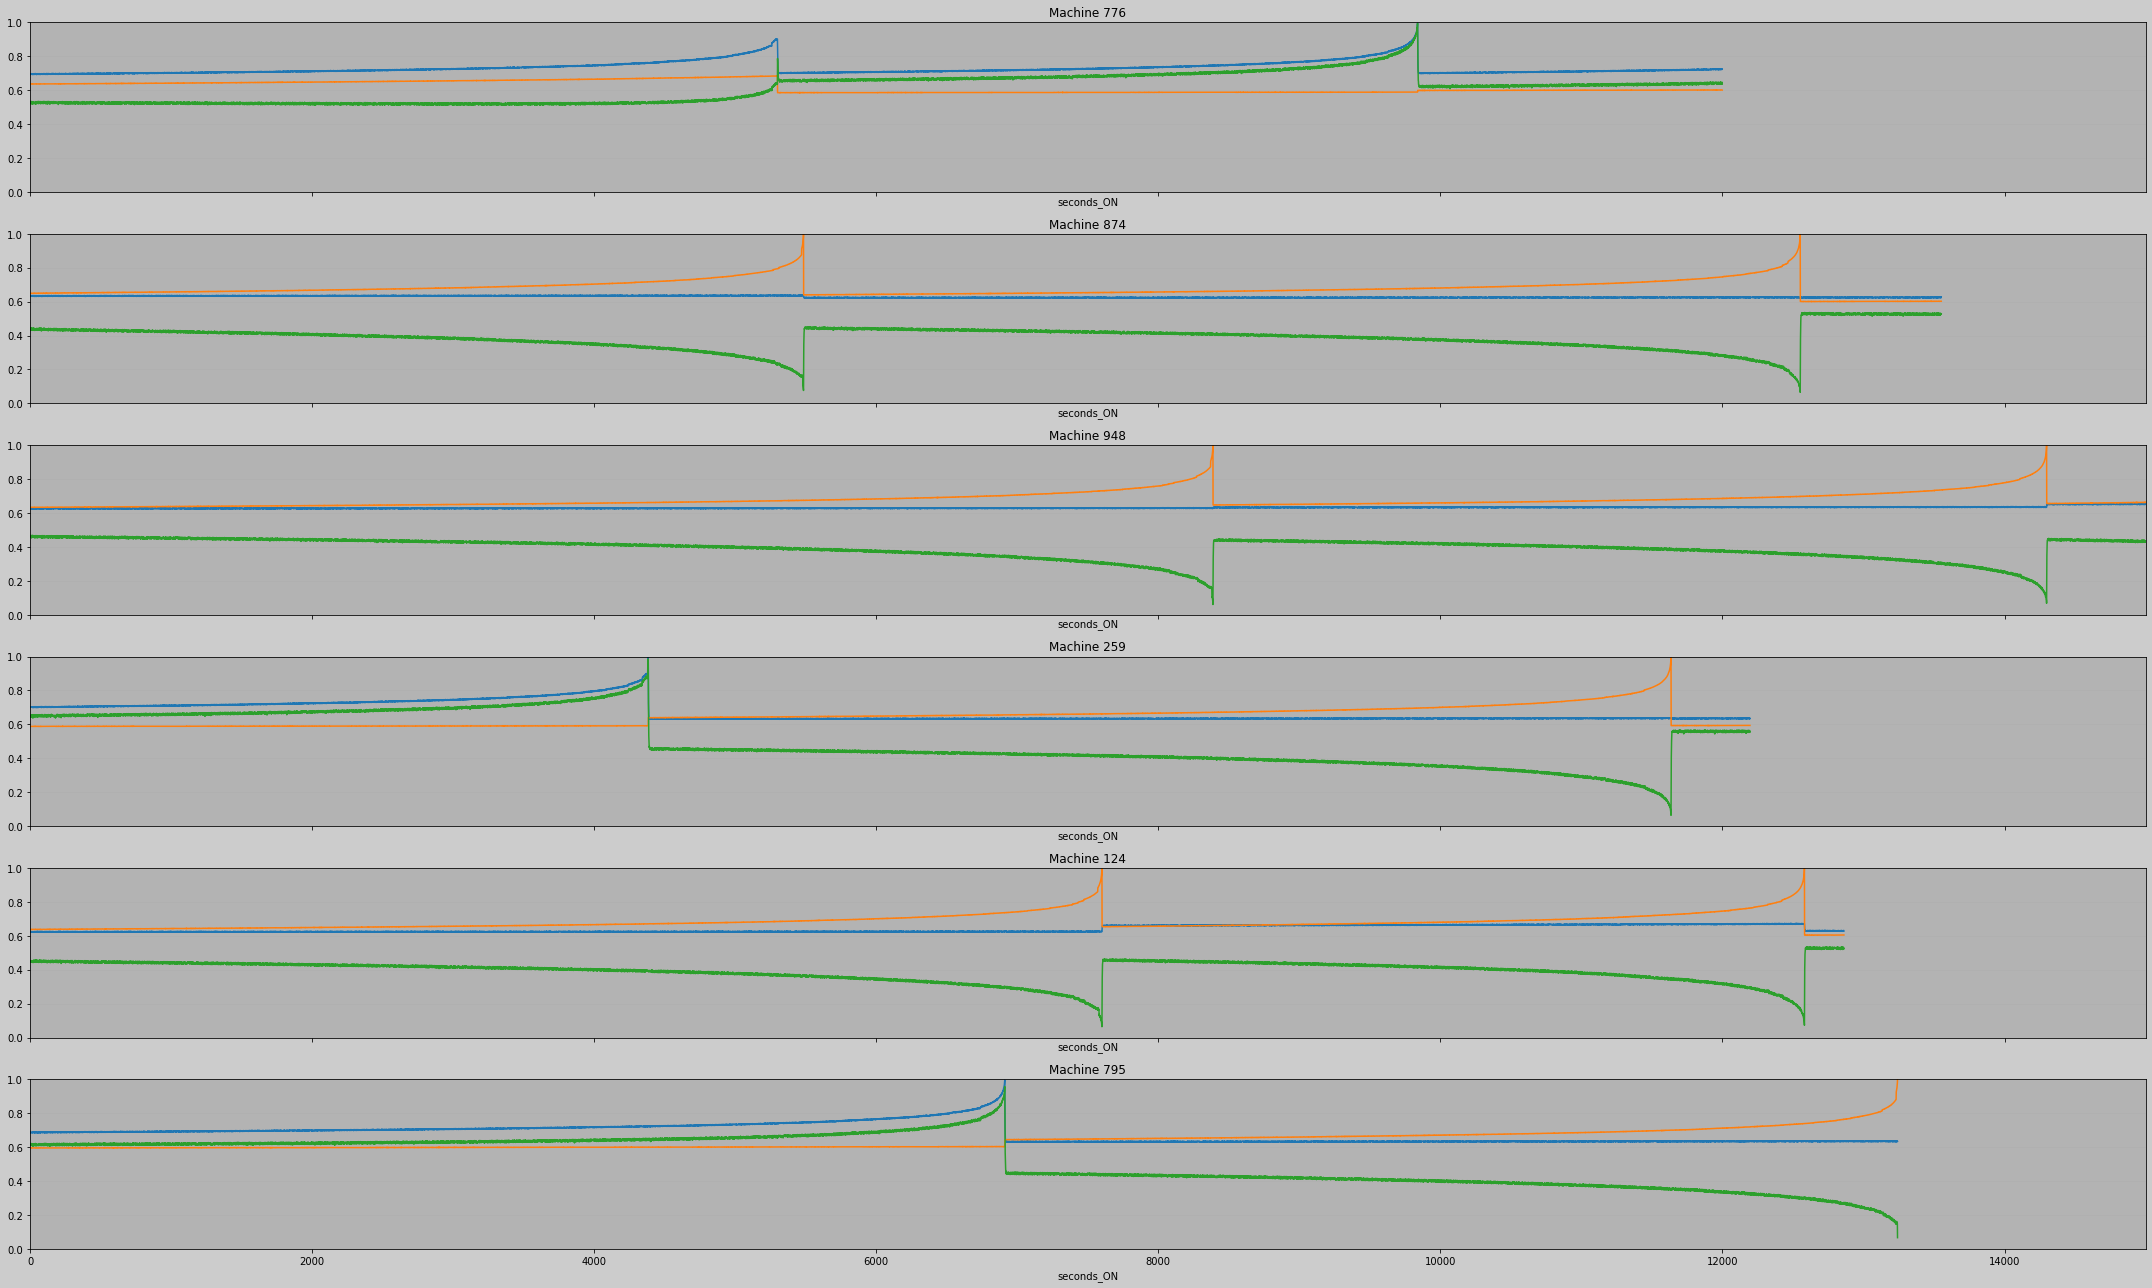

In [21]:
# Affichage des machines ayant eu deux pannes
logs_int_nofix = logs_int.drop(logs_int[logs_int["code"] == 0].index)
logs_int_nofix["dupl"] = logs_int_nofix.duplicated(subset="machineID")
l_dup = logs_int_nofix[logs_int_nofix["dupl"]]["machineID"].tolist()
m = len(l_dup)
fig, axs = plt.subplots(m, 1, sharex=True, sharey=True, figsize=(30, m * 3))
for j, i in enumerate(l_dup):
    df = parc_lisse[i].reset_index(inplace=False)
    axs[j].plot(df[["speed", "temperature", "pressure"]])
    axs[j].set_title('Machine '+str(i))
    axs[j].set_xlabel("seconds_ON")
    axs[j].set_xlim([0, 15_000])
    axs[j].set_ylim([0, 1])
    axs[j].grid(axis='y')
    axs[j].figsize=(20, 5)
    axs[j].set_facecolor("0.7")
fig.set_facecolor("0.8")
plt.tight_layout()
plt.show()

# Etiquetage

On ajoute aux données du parc les "temps-avant-panne" pour chaque type de panne (ainsi que les "temps-depuis-réparation"), toujours comptés en "secondes_ON".
On commence donc par construire un DataFrame `logs_ON` qui ajoute ces données à `logs_int`.

On choisit une durée maximum pour les temps-avant-panne, `maxi`, c'est-à-dire que dès que l'on sait qu'une machine ne connaîtra pas de panne pendant les `maxi` prochaines secondes, alors on indique que le temps-avant-panne est `maxi` (même si on sait que c'est `maxi` + 1000). Ce maximum sert aussi à enlever certaines données: si on a une donnée de télémétrie à moins de `maxi` de la fin des mesures (à m, alors on se peut connaître le temps avant panne.

Augmenter `maxi` permet donc de prédire des pannes plus lointaines, mais enlève des données d'entraînement. (On peut peut-être contourner un peu le problème en prenant deux maximums différents pour chacun de ces rôles.)

Le but final reste à préciser avec le client:
- savoir dans combien de temps une machine donnée va tomber en panne ?
- connaître la probabilité qu'elle tombe en panne dans le prochain cycle allumé (quelques minutes), ou dans les prochaines heures ?

Dans tous les cas, l'étiquetage par "secondes-avant-pannes" semble être la bonne premier étape.

Les graphes montrent que la température est un bon prédicteur pour les pannes de type F1 et la vitesse pour les pannes de type F2. La pression décroît avant les pannes de type F1 et croît avant celles de type F2.

In [22]:
def logsON(logs: pd.DataFrame = logs_int, parc_lisse: List[pd.DataFrame] = parc_lisse) -> pd.DataFrame:
    """Retourne un DataFrame de logs avec une colonne supplémentaire
    'seconds_ON' qui indique le nombre de secondes écoulées où la machine
    donnée est en fonctionnement.
    """
    df = logs.copy()
    df["seconds_ON"] = pd.NA
    for event in df.itertuples():
        df1 = parc_lisse[event.machineID]
        if event.code != 0:
            # on indique pour "seconds_ON" le dernier instant où la
            # machine est en fonctionnement avant de tomber en panne
            df.loc[event.Index,"seconds_ON"] = np.max(np.asarray(df1['seconds'] <= event.seconds).nonzero()[0])
        else:
            # on indique le premier instant "ON" après une réparation
            df2 = np.asarray(df1['seconds'] >= event.seconds).nonzero()[0]
            if df2.size != 0:
                df.loc[event.Index,"seconds_ON"] = np.min(df2)
            else:
                # s'il n'y a pas de tel instant (en fin de période),
                # alors on prend le dernier instant "ON" avant la panne
                df.loc[event.Index,"seconds_ON"] = np.max(np.asarray(df1['seconds'] <= event.seconds).nonzero()[0])
    return df

In [23]:
logs_ON = logsON(logs_int, parc_lisse)
#display(logs_ON.head(1))

In [24]:
def recupere_pannes(logs: pd.DataFrame = logs_int) -> [List[List[int]], List[List[int]], List[List[int]]]:
    """Retourne une liste de trois listes, où dans chacune, l'élément indicé
    par le machineID est la liste des instants de réparation (0) ou de panne
    de type 1 ou 2, respectivement.
    """
    pannes = [[[] for _ in range(1000)] for i in range(3)]
    for row in logs.itertuples(index=False):
        pannes[row.code][row.machineID].append(row.seconds_ON)
    return pannes

In [25]:
pannes = recupere_pannes(logs_ON)

In [26]:
def etiquette_machine(tele_lisse: pd.DataFrame, pannes = pannes, maxi: int = 100 * 60) -> pd.DataFrame:
    """Retourne le DataFrame étiqueté associé au DataFrame donné. Les
    étiquettes sont les quatres colonnes donnant les temps jusqu'à la
    prochaine panne, la prochaine panne de type F1 ou F2, et depuis la
    dernière réparation.
    """
    df = tele_lisse.copy()
    mac = int(df.iloc[0]["machineID"])
    #df = parc_lisse[mac].copy()
    s = df.index.isin(pannes[0][mac]).cumsum()
    df["from_fix"] = np.where(s>0,df.groupby(s).cumcount(), np.nan)
    first_fix = pannes[0][mac][0] if pannes[0][mac] else len(df)
    if maxi < first_fix:
        df.loc[maxi:first_fix, "from_fix"] = maxi
    for code in range(1, 3):
        s = df[::-1].index.isin(pannes[code][mac]).cumsum()[::-1]
        st = "to_F" + str(code)
        df[st] = np.where(s>0,df.groupby(s).cumcount(ascending=False), np.nan)
    last_break = max(pannes[1][mac][-1] if pannes[1][mac] else -1, pannes[2][mac][-1] if pannes[2][mac] else -1)
    if last_break < len(df) - maxi:
        df.loc[last_break + 1:len(df) - maxi, "to_F1"] = maxi
        df.loc[last_break + 1:len(df) - maxi, "to_F2"] = maxi
    df["to_break"] = np.fmin(df["to_F1"], df["to_F2"])
    df[["from_fix", "to_F1", "to_F2", "to_break"]] = df[["from_fix", "to_F1", "to_F2", "to_break"]].clip(upper=maxi)
    # on ne voit que la prochaine panne, pas la suivante:
    df["to_F1"] = np.where(df["to_F2"] < df["to_F1"], np.nan, df["to_F1"])
    df["to_F2"] = np.where(df["to_F1"] < df["to_F2"], np.nan, df["to_F2"])    
    return df

In [27]:
%%time
# Création du parc étiqueté:
parc_etiquete = [etiquette_machine(tele_lisse, pannes=pannes, maxi=100 * 60) for tele_lisse in parc_lisse]
#display(parc_etiquete[0].head(1))

CPU times: user 9.92 s, sys: 252 ms, total: 10.2 s
Wall time: 10.2 s


In [28]:
maxi = 100 * 60 # 100 minutes (1h 40min) de fonctionnement

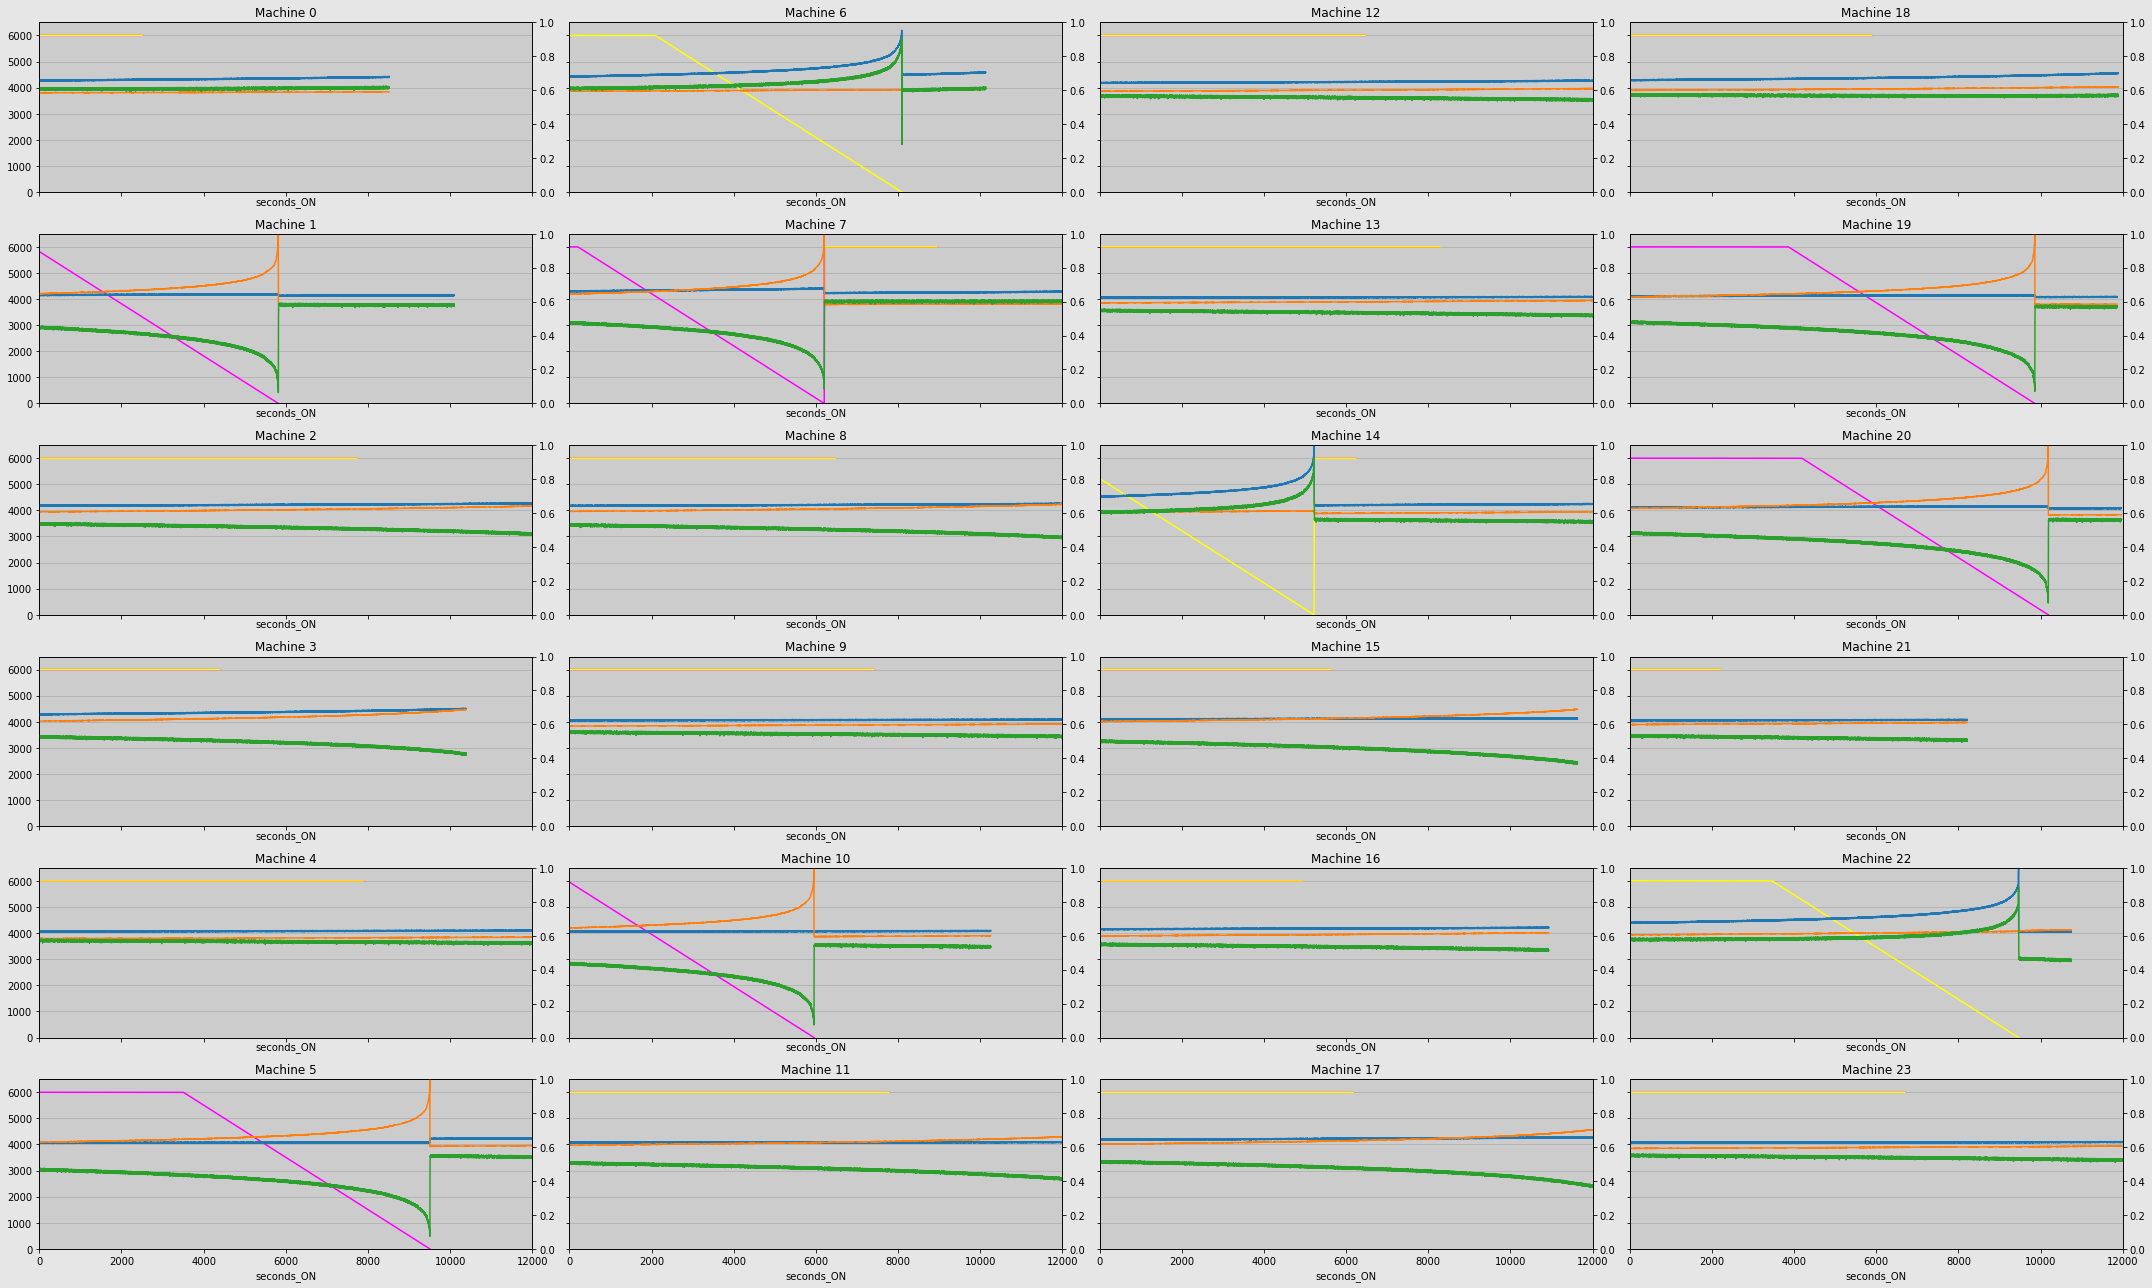

In [29]:
# Affichage de n machines sur col colonnes, avec temps avant pannes
n = 24
col = 4
m = 1 + (n - 1) // col
fig, axs = plt.subplots(m, col, sharex=True, sharey=True, figsize=(30, n * 3 / col))
axs2 = axs[:]
for i in range(n):
    j = (i % m, i // m)
    df = parc_etiquete[i].reset_index(inplace=False)
    axs[j].plot(df["to_F1"], c=(1,0,1))
    axs[j].plot(df["to_F2"], c=(1,1,0))
    axs[j].set_title('Machine '+str(i))
    axs[j].set_xlabel("seconds_ON")
    axs[j].set_xlim([0, 12_000])
    axs[j].set_ylim([0, maxi + 500])
    axs[j].grid(axis='y')
    axs[j].figsize=(20, 5)
    axs[j].set_facecolor("0.8")
    axs2[j] = axs[j].twinx()
    axs2[j].plot(df[["speed", "temperature", "pressure"]])
    axs2[j].set_ylim([0, 1])
fig.set_facecolor("0.9")
plt.tight_layout()
plt.show()

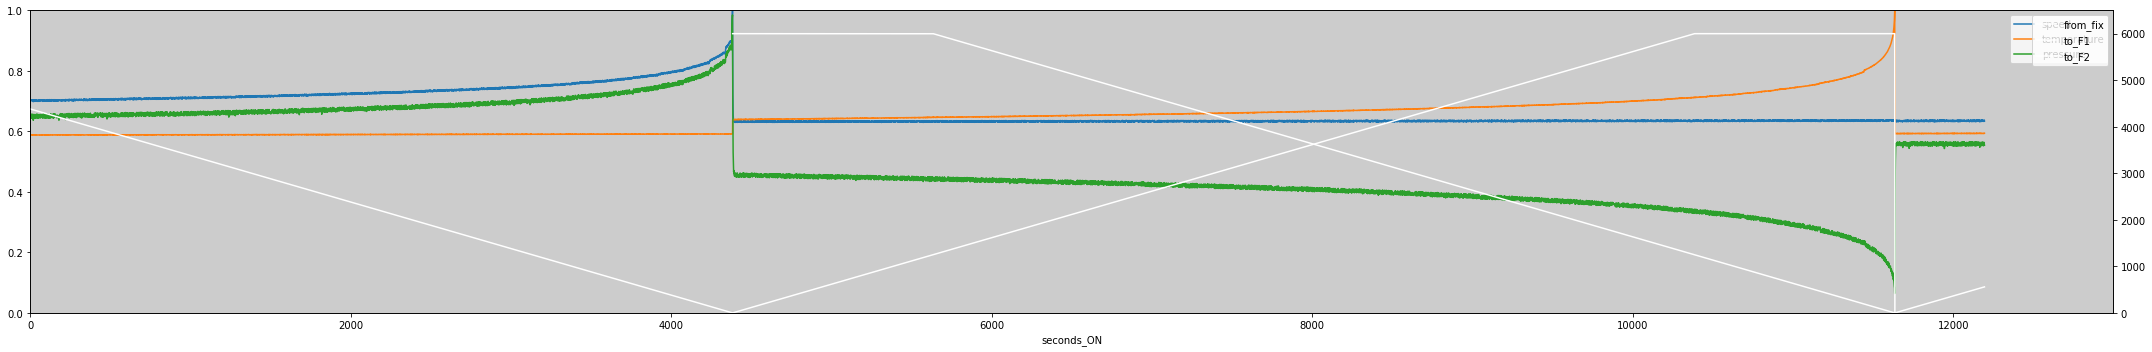

In [30]:
# Affichage pour une machine ayant connu une panne de chaque code.
ax = plt.gca()
parc_etiquete[259].plot(y=["speed", "temperature", "pressure"], ax=ax, figsize=(30, 5))
ax.set_xlim([0, 13_000])
ax.set_ylim([0, 1])
ax.set_facecolor("0.8")
ax2 = ax.twinx()
parc_etiquete[259].plot(y=["from_fix", "to_F1", "to_F2"], ax=ax2, figsize=(30, 5), c=(1,1,1))
ax2.set_ylim([0, maxi + 500])
ax2.set_facecolor("0.8")
plt.tight_layout()
plt.show()

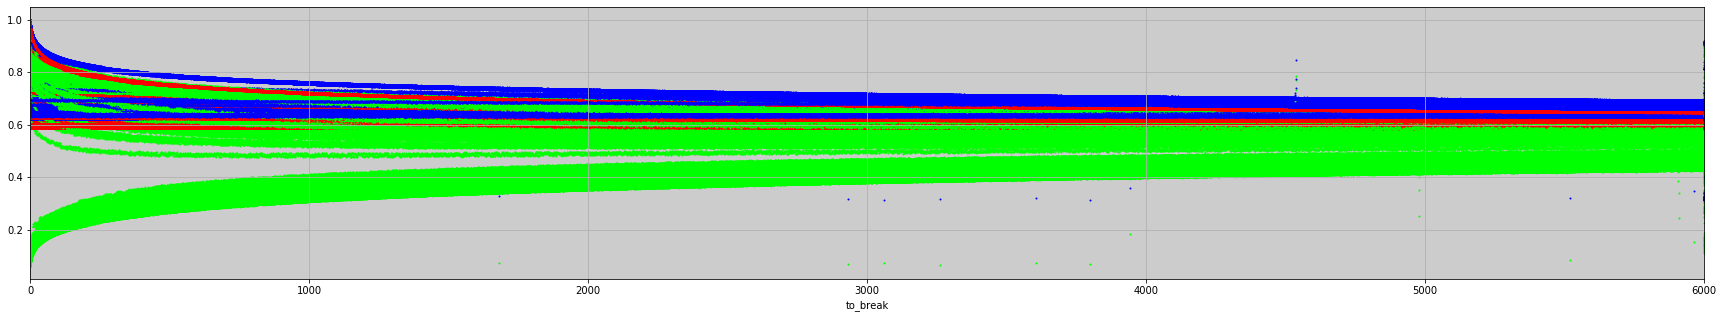

In [31]:
# Affichage des conditions en fonction du temps-avant-panne pour les n premières machines.
# On voit que ce sera difficilement prédictible: heureusement, les données de maintenance
# précisent le type de panne.
n = 1000
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_etiquete[i]["to_break"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_etiquete[i]["to_break"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_etiquete[i]["to_break"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_break")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

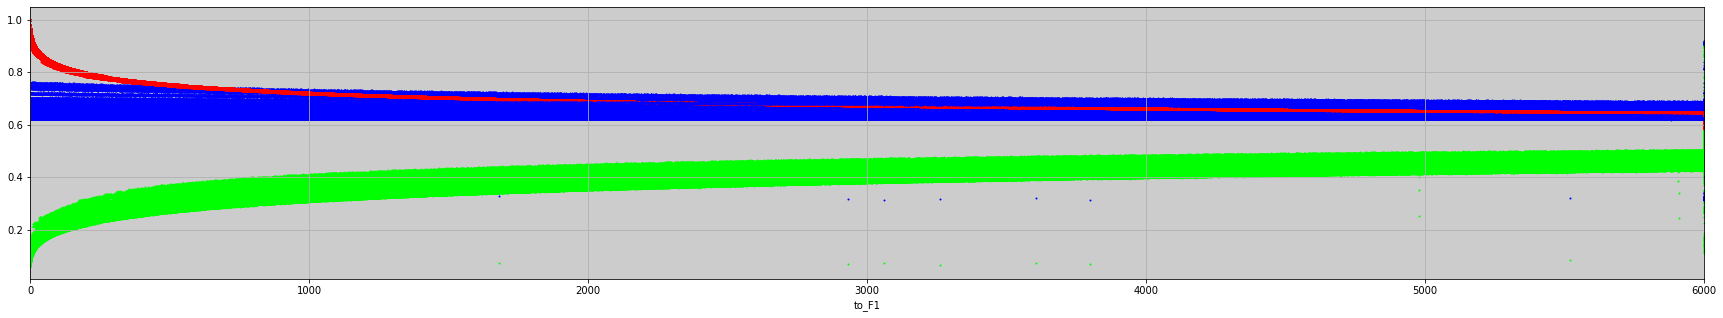

In [32]:
# Affichage des conditions en fonction du temps-avant-panne F1 pour les n premières machines.
# On voit que la température sera le principal prédicteur pour la panne F1.
n = 1000
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

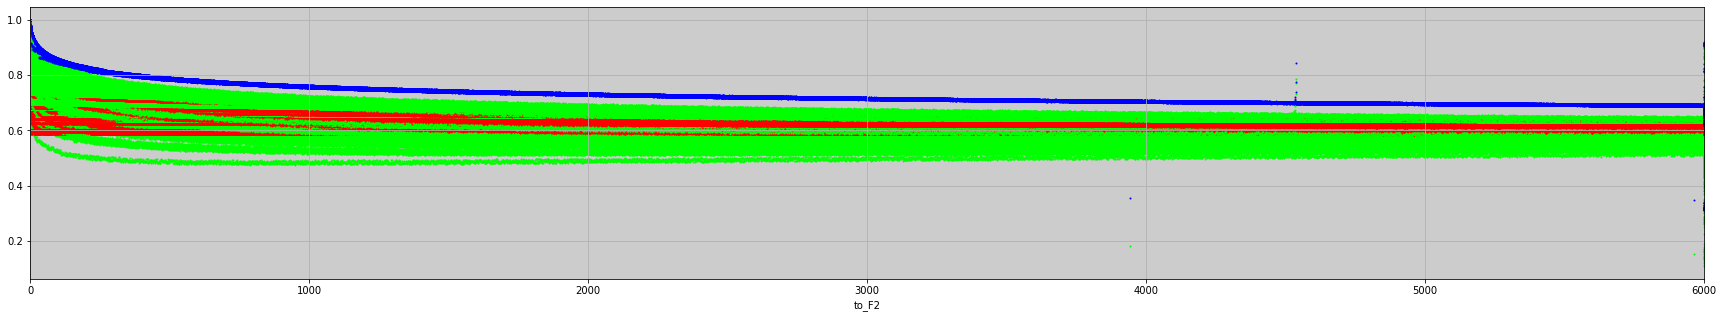

In [33]:
# Affichage des conditions en fonction du temps-avant-panne F2 pour les n premières machines.
# On voit que la vitesse sera le principal prédicteur pour la panne F2.
n = 1000
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F2")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

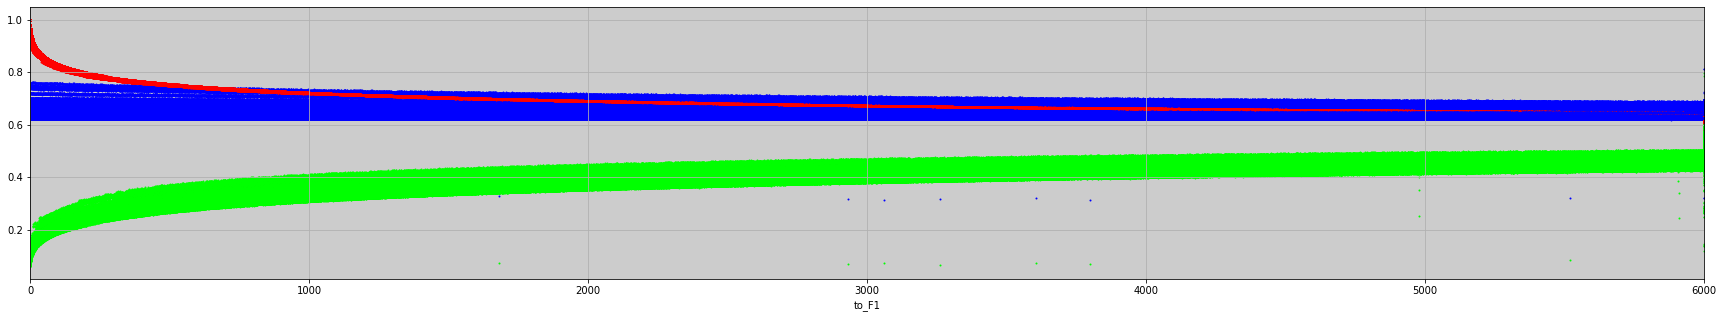

CPU times: user 23.7 s, sys: 10.5 s, total: 34.3 s
Wall time: 18.3 s


In [34]:
%%time
# Affichage des conditions en fonction du temps-avant-panne F1 pour les machines ayant eu une panne F1.
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in mac_panne[0]:
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

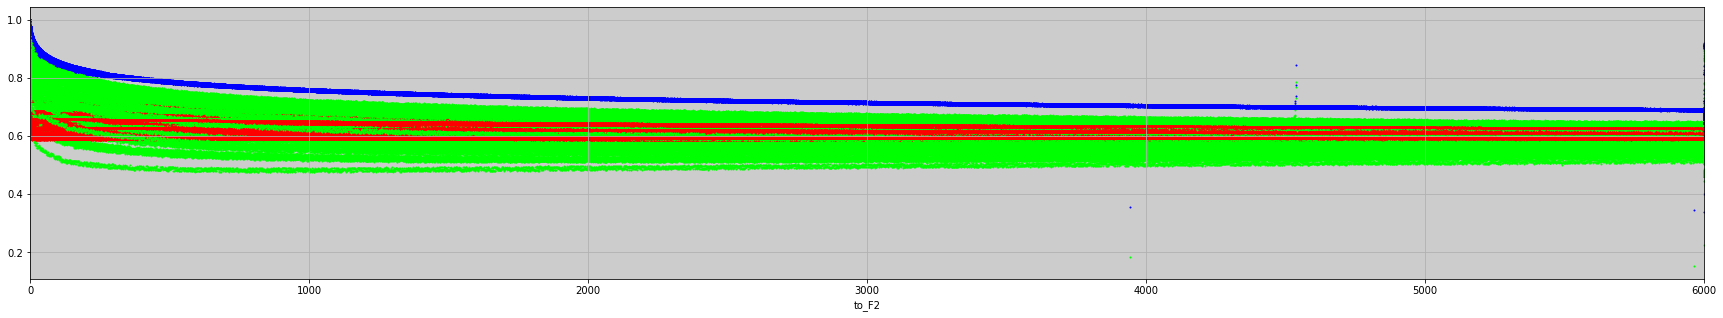

CPU times: user 9.43 s, sys: 4.14 s, total: 13.6 s
Wall time: 7.31 s


In [35]:
%%time
# Affichage des conditions en fonction du temps-avant-panne F2 pour les machines ayant eu une panne F2.
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in mac_panne[1]:
    ax.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_etiquete[i]["to_F2"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F2")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

# Régression (fausse piste)
Pour à la fois lisser les données et ajouter un "indice" au ML, on fait des régressions linéaires des conditions (vitesse, température, pression) de chaque machine à chaque instant, sur les `delai=10` secondes précédentes.
Il doit exister des méthodes pour faire des régressions "glissantes" plus rapidement, mais ici `delai` reste petit.

In [36]:
def linreg(l):
    """A partir d'une liste d'entiers l, retourne le couple (pente, intercept) donnée
    par régression linéaire classique (moindres carrés) du nuage de points
    {(1-m, l[0]), (2-m, l[1]), ..., (0, l[m-1])}
    où m est la longueur de l.
    
    Appelée sur une liste de listes, la fonction retourn une liste de couples
    (pente, intercept) pour chaque régression.
    """
    m = len(l)
    a = np.arange(1-m, 1).reshape(m, 1)
    res = np.array(list(l))
    reg = LinearRegression().fit(a, l)
    try:
        coefs = np.block(reg.coef_.transpose())[0]
    except IndexError:
        coefs = np.block(reg.coef_.transpose())
    intercepts = reg.intercept_
    return coefs, intercepts

In [37]:
def regress(tele_etiquete: pd.DataFrame, delai: int = 10) -> pd.DataFrame:
    """Retourn un DataFrame avec des colonnes supplémentaires avec les données
    de régression des conditions.
    """
    df = tele_etiquete.copy()
    for i in range(delai + 1): #on répète la colonne à l'instant donné (i=0) par simplicité
        si = "speed" + str(i)
        ti = "temp" + str(i)
        pi = "press" + str(i)
        df[si] = df["speed"].shift(i)
        df[ti] = df["temperature"].shift(i)
        df[pi] = df["pressure"].shift(i)
    # Suppression des "delai" première données, puisque l'historique n'est pas disponible
    df = df.iloc[delai:]
    # Suppression des données juste après une réparation, puisque l'historique n'est pas pertinent
    # (on pourrait aussi imposer pour la regression une pente de 0 et une moyenne égale à la valeur
    # présente, mais le nombre de données est négligeable).
    df = df[~(df["from_fix"] <= delai)]
    # Calcul des régressions:
    df["speed_slope"], df["speed_0"] = linreg([df["speed"+str(i)] for i in range(delai+1)])
    df["temp_slope"], df["temp_0"] = linreg([df["temp"+str(i)] for i in range(delai+1)])
    df["press_slope"], df["press_0"] = linreg([df["press"+str(i)] for i in range(delai+1)])
    # Suppression des colonnes temporaires:
    for i in range(delai + 1):
        si = "speed" + str(i)
        ti = "temp" + str(i)
        pi = "press" + str(i)
        df = df.drop([si, ti, pi], axis=1)
    return df

In [38]:
%%time
# Création du parc avec régressions:
parc_reg = [regress(tele_etiquete, delai=15) for tele_etiquete in parc_etiquete]
#display(parc_reg[0].head(1))

CPU times: user 8min 29s, sys: 9min 57s, total: 18min 27s
Wall time: 3min 12s


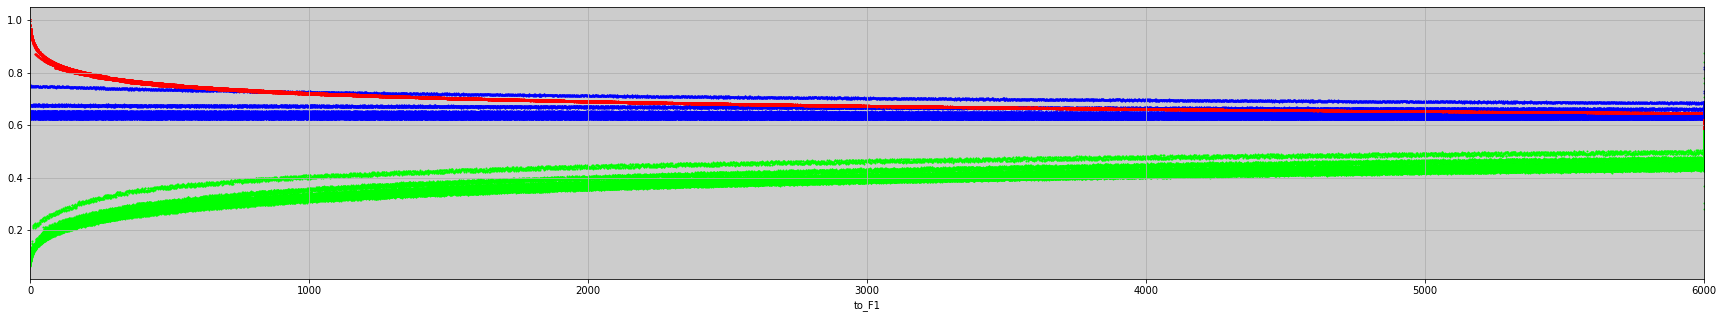

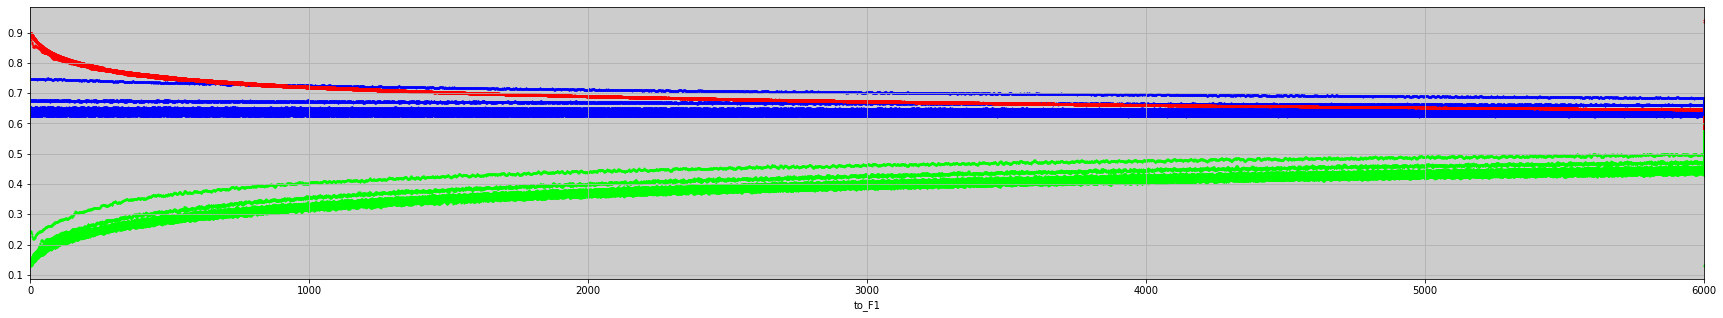

In [39]:
# Affichage des conditions en fonction du temps-avant-panne F1 pour les n premières machines.
# Le coefficient constant de la régression agit comme une moyen et lisse: le deuxième graphe
# est un peu plus propre, particulièrement pour la pression.
n = 100
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["temp_0"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["press_0"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["speed_0"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

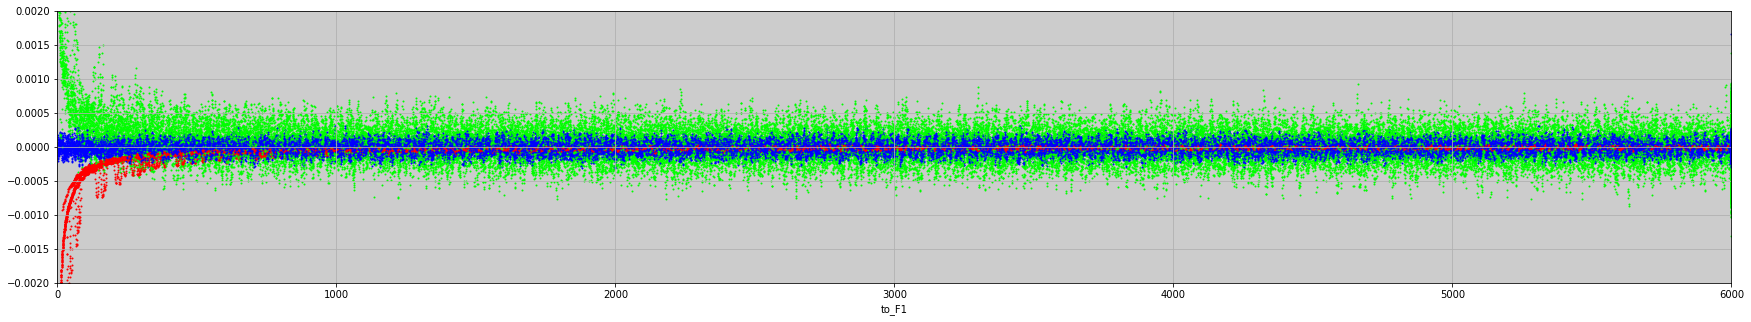

In [40]:
# Affichage des pentes
n = 30
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["temp_slope"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["press_slope"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_reg[i]["to_F1"], y=parc_reg[i]["speed_slope"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_ylim(-0.002, 0.002)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

La régression était donc une fausse piste.

# Lissage par moyenne
Puisque le terme constant des régressions a lissé les courbes, autant calculer une véritable moyenne sur les `delai=10` secondes précédentes.

In [41]:
def moyennage(tele_etiquete: pd.DataFrame, delai: int = 10) -> pd.DataFrame:
    df = tele_etiquete.copy()
    for i in range(delai + 1): #on répète la colonne à l'instant donné (i=0) par simplicité
        si = "speed" + str(i)
        ti = "temp" + str(i)
        pi = "press" + str(i)
        df[ti] = df["temperature"].shift(i)
        df[pi] = df["pressure"].shift(i)
        df[si] = df["speed"].shift(i)
    # Suppression des "delai" première données, puisque l'historique n'est pas disponible:
    df = df.iloc[delai:]
    # Suppression des données juste après une réparation, puisque l'historique n'est pas pertinent
    # (on pourrait aussi imposer une moyenne égale à la valeur
    # présente, mais le nombre de données est négligeable).
    df = df[~(df["from_fix"] <= delai)]
    # Calcul des moyennes:
    df["temp_mean"] = df[["temp"+str(i) for i in range(delai+1)]].mean(axis=1)
    df["press_mean"] = df[["press"+str(i) for i in range(delai+1)]].mean(axis=1)
    df["speed_mean"] = df[["speed"+str(i) for i in range(delai+1)]].mean(axis=1)
    # Suppression des colonnes temporaires:
    for i in range(delai + 1):
        ti = "temp" + str(i)
        pi = "press" + str(i)
        si = "speed" + str(i)
        df = df.drop([ti, pi, si], axis=1)
    return df

In [42]:
%%time
# Création du parc avec moyennage:
parc_moy = [moyennage(tele_etiquete, delai=15) for tele_etiquete in parc_etiquete]
#display(parc_moy[0].head(1))

CPU times: user 44.6 s, sys: 350 ms, total: 44.9 s
Wall time: 45.1 s


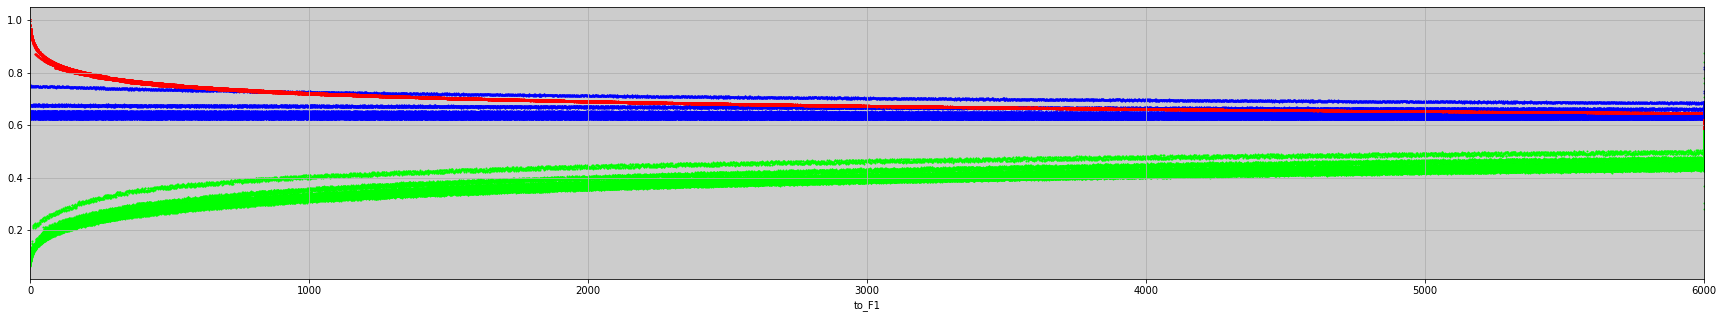

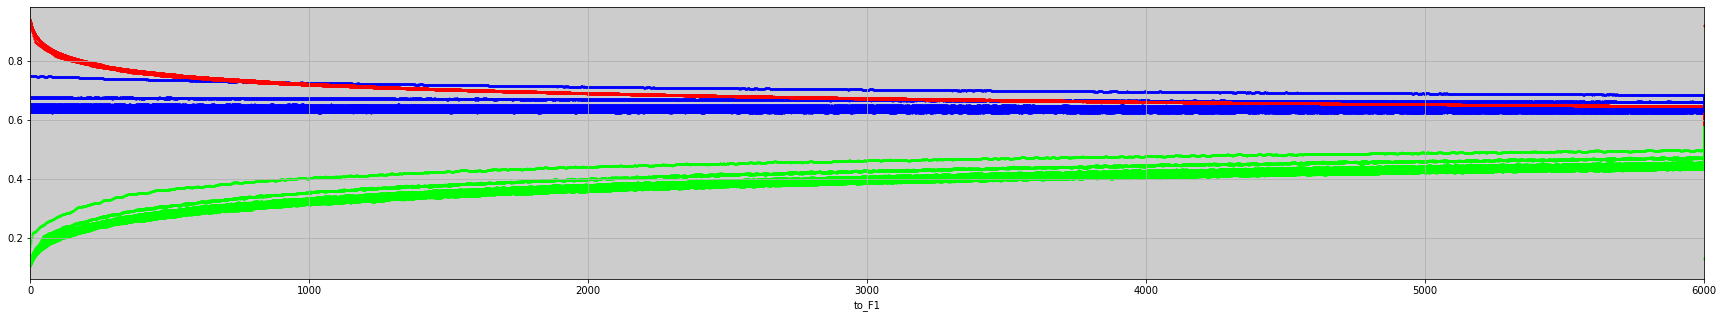

In [43]:
# Affichage des conditions en fonction du temps-avant-panne F1 pour les n premières machines.
# La moyenne lisse les courbes: le deuxième graphe est plus propre, particulièrement pour
# la pression.
n = 100
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["temperature"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["pressure"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_etiquete[i]["to_F1"], y=parc_etiquete[i]["speed"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["press_mean"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["speed_mean"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

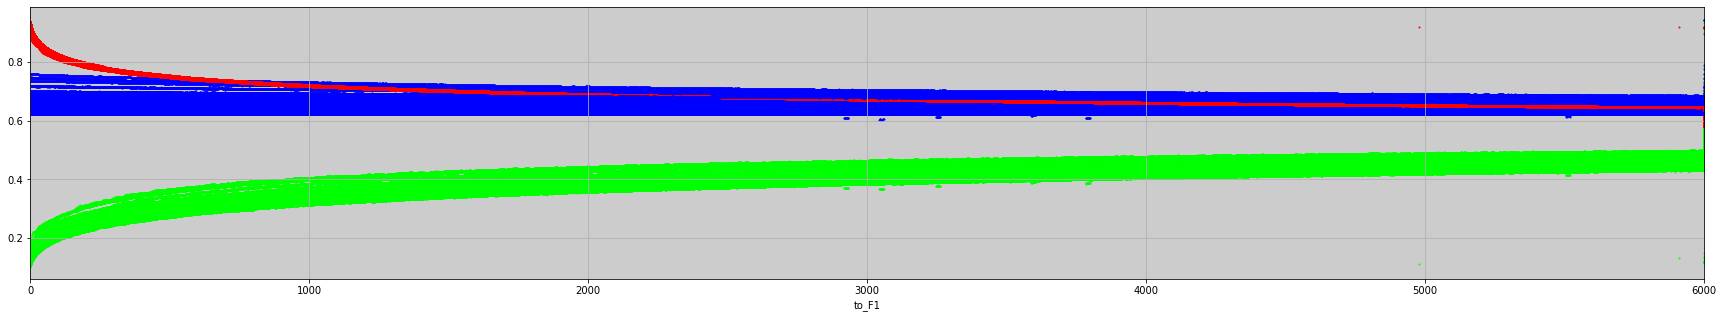

In [44]:
# Affichage des conditions moyennes pour l'ensemble du parc; panneF1.
n = 1000
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["press_mean"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_moy[i]["to_F1"], y=parc_moy[i]["speed_mean"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

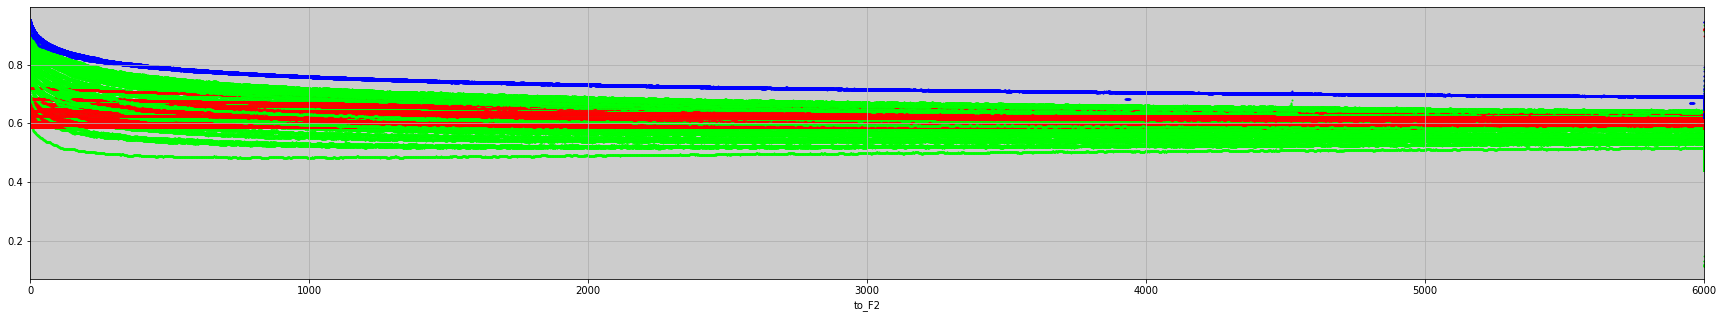

In [45]:
# Affichage des conditions moyennes pour l'ensemble du parc; panne F2.
n = 1000
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_moy[i]["to_F2"], y=parc_moy[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_moy[i]["to_F2"], y=parc_moy[i]["press_mean"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_moy[i]["to_F2"], y=parc_moy[i]["speed_mean"], s=1, c=[[0,0,1]])
ax.set_xlabel("to_F2")
ax.set_xlim(0, maxi)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

# Calcul des "dérivées" des conditions (fausse piste)

In [46]:
# Les dérivées des conditions pourraient éventuellement aider.
def cond_diff(tele_moy: pd.DataFrame, delai: int = 50) -> pd.DataFrame:
    df = tele_moy.copy()
    df["temp_delai"] = df["temperature"].shift(delai)
    df["press_delai"] = df["pressure"].shift(delai)
    df["speed_delai"] = df["speed"].shift(delai)
    # effacer les "delai" première données, puisque l'historique n'est pas disponible
    df = df.iloc[delai:]
    # effacer les données juste après une réparation, puisque l'historique n'est pas pertinent
    # (on pourrait aussi imposer pour la regression une pente de 0 et une moyenne égale à la valeur
    # présente, mais le nombre de données est négligeable).
    df = df[~(df["from_fix"] <= delai)]
    df["temp_diff"] = (1000 / delai) * (df["temperature"] - df["temp_delai"])
    df["press_diff"] = (1000 / delai) * (df["pressure"] - df["press_delai"])
    df["speed_diff"] = (1000 / delai) * (df["speed"] - df["speed_delai"])
    df = df.drop(["temp_delai", "press_delai", "speed_delai"], axis=1)
    return df

In [47]:
%%time
# Création du parc avec dérivées des conditions:
parc_diff = [cond_diff(tele_moy, delai=100) for tele_moy in parc_moy]
#display(parc_diff[0].head(1))

CPU times: user 5.24 s, sys: 245 ms, total: 5.48 s
Wall time: 5.48 s


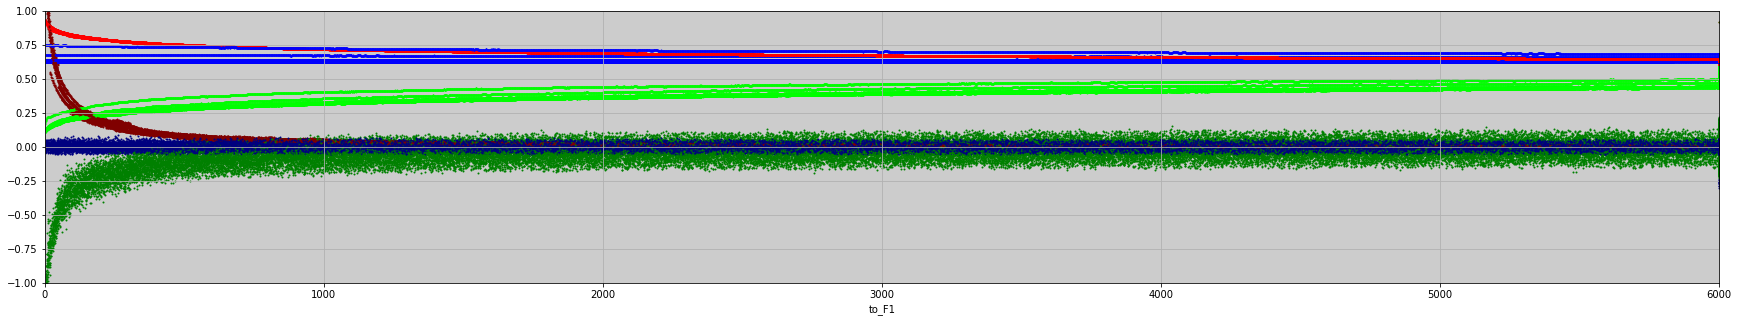

In [48]:
# Affichage des conditions et de leurs dérivées; panne F1.
n = 30
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["press_mean"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["speed_mean"], s=1, c=[[0,0,1]])
    ax.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["temp_diff"], s=1, c=[[0.5, 0, 0]])
    ax.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["press_diff"], s=1, c=[[0, 0.5, 0]])
    ax.scatter(x=parc_diff[i]["to_F1"], y=parc_diff[i]["speed_diff"], s=1, c=[[0, 0, 0.5]])
ax.set_xlabel("to_F1")
ax.set_xlim(0, maxi)
ax.set_ylim(-1, 1)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

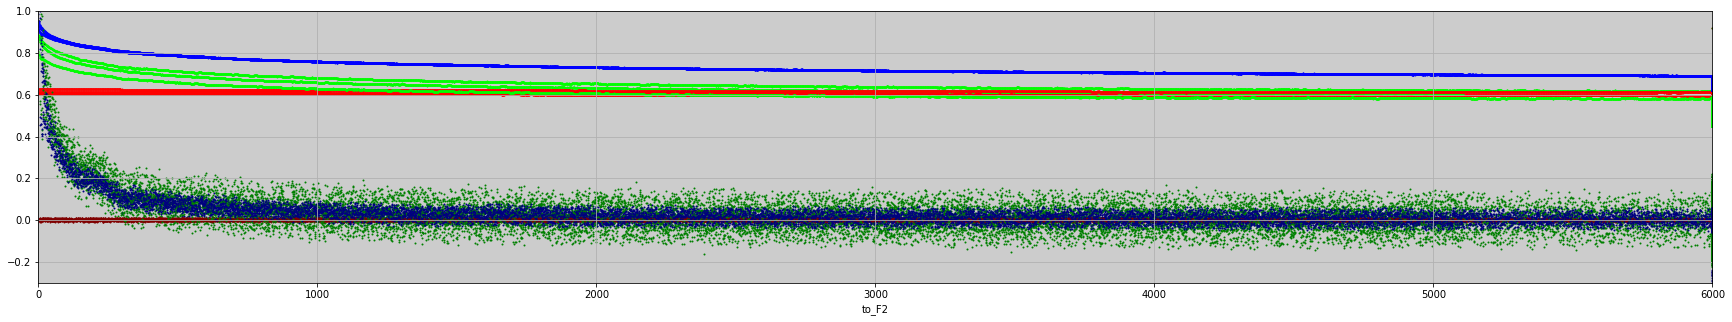

In [49]:
# Affichage des conditions et de leurs dérivées; panne F2.
n = 30
fig, ax = plt.subplots(1, 1, figsize=(30, 5))
for i in range(n):
    ax.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["temp_mean"], s=1, c=[[1,0,0]])
    ax.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["press_mean"], s=1, c=[[0,1,0]])
    ax.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["speed_mean"], s=1, c=[[0,0,1]])
    ax.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["temp_diff"], s=1, c=[[0.5, 0, 0]])
    ax.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["press_diff"], s=1, c=[[0, 0.5, 0]])
    ax.scatter(x=parc_diff[i]["to_F2"], y=parc_diff[i]["speed_diff"], s=1, c=[[0, 0, 0.5]])
ax.set_xlabel("to_F2")
ax.set_xlim(0, maxi)
ax.set_ylim(-0.3, 1)
ax.set_facecolor("0.8")
ax.grid(True)
plt.show()

Les dérivées étaient probablement une fausse piste. De façon générale, une dérivée est trop sensible au bruit (la dérivation est une opération instable).

# Visualisation simulanée de deux paramètres (3D)

Visualisation des temps-avant-panne en fonction de deux des trois paramètres, pour chaque code de panne.
(On ne représente les données que pour les machines connaissant effectivement une panne du type donné.)

On voit quelques artefacts qu'il serait peut-être utile d'enlever avant le ML (il y en aurait plus si on représentait l'ensemble des machines; ils sont déjà visibles sur les graphes ci-dessus).

In [50]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

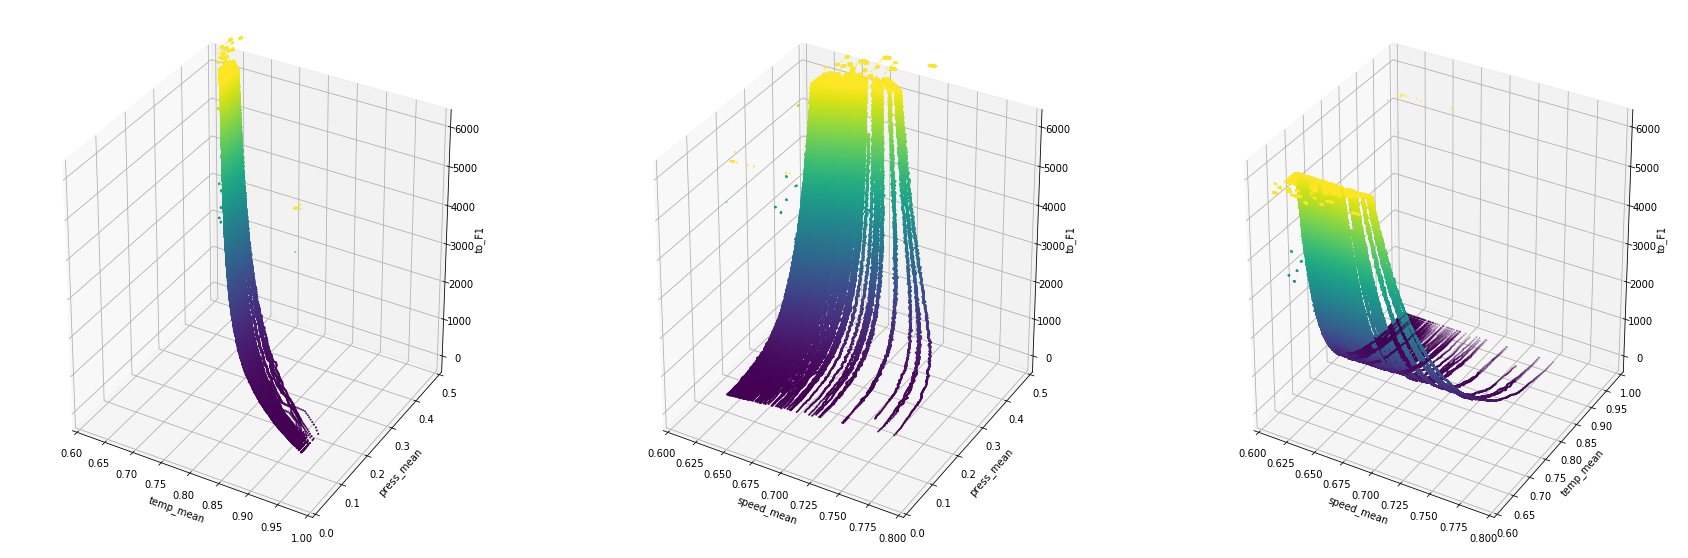

CPU times: user 1min 28s, sys: 846 ms, total: 1min 29s
Wall time: 1min 29s


In [51]:
%%time
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(131, projection='3d')
for i in mac_panne[0]:
    z = parc_moy[i]["to_F1"]
    ax.scatter(xs=parc_moy[i]["temp_mean"], ys=parc_moy[i]["press_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 1)
ax.set_ylim(0, .5)
ax.set_xlabel('temp_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(132, projection='3d')
for i in mac_panne[0]:
    z = parc_moy[i]["to_F1"]
    ax.scatter(xs=parc_moy[i]["speed_mean"], ys=parc_moy[i]["press_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 0.8)
ax.set_ylim(0, .5)
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(133, projection='3d')
for i in mac_panne[0]:
    z = parc_moy[i]["to_F1"]
    ax.scatter(xs=parc_moy[i]["speed_mean"], ys=parc_moy[i]["temp_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 0.8)
ax.set_ylim(.6, 1)
ax.set_xlabel('speed_mean')
ax.set_ylabel('temp_mean')
ax.set_zlabel('to_F1')
plt.show()

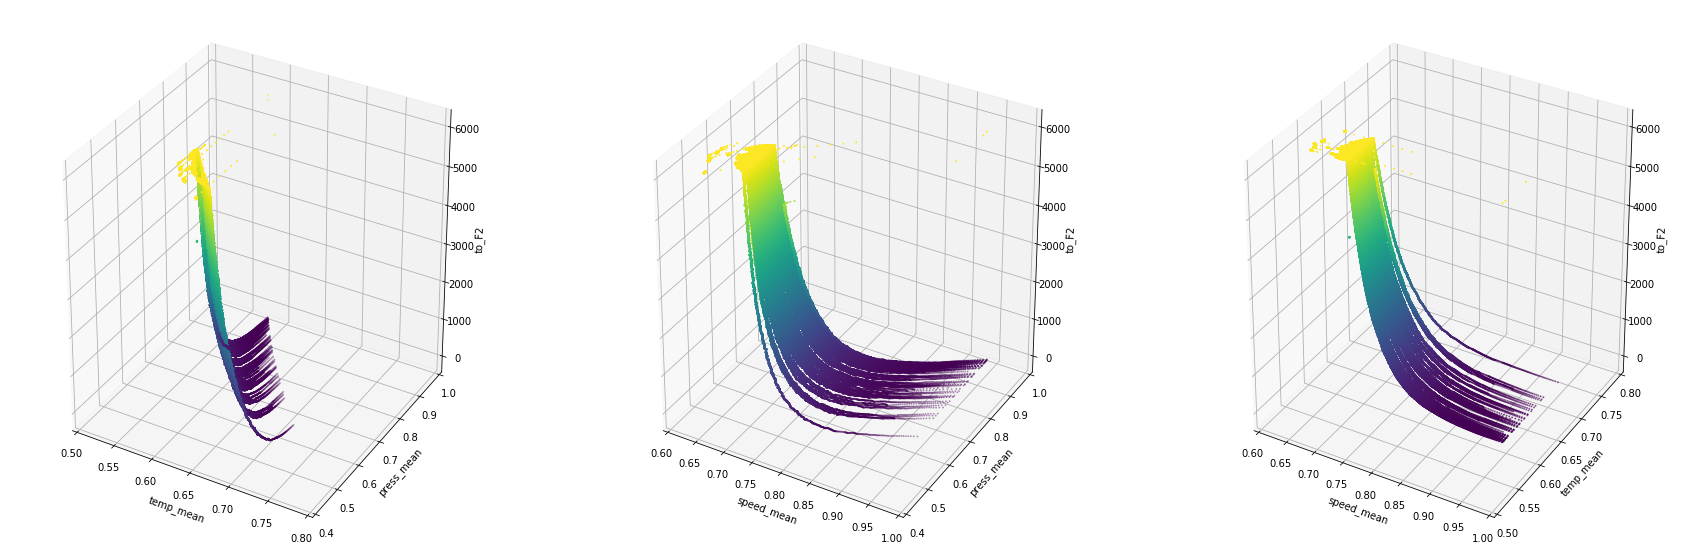

CPU times: user 34.4 s, sys: 593 ms, total: 35 s
Wall time: 34.3 s


In [52]:
%%time
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(131, projection='3d')
for i in mac_panne[1]:
    z = parc_moy[i]["to_F2"]
    ax.scatter(xs=parc_moy[i]["temp_mean"], ys=parc_moy[i]["press_mean"], zs=z, s=1, c=z)
ax.set_xlim(.5, .8)
ax.set_ylim(.4, 1)
ax.set_xlabel('temp_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F2')

ax = fig.add_subplot(132, projection='3d')
for i in mac_panne[1]:
    z = parc_moy[i]["to_F2"]
    ax.scatter(xs=parc_moy[i]["speed_mean"], ys=parc_moy[i]["press_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 1)
ax.set_ylim(.4, 1)
ax.set_xlabel('speed_mean')
ax.set_ylabel('press_mean')
ax.set_zlabel('to_F2')

ax = fig.add_subplot(133, projection='3d')
for i in mac_panne[1]:
    z = parc_moy[i]["to_F2"]
    ax.scatter(xs=parc_moy[i]["speed_mean"], ys=parc_moy[i]["temp_mean"], zs=z, s=1, c=z)
ax.set_xlim(.6, 1)
ax.set_ylim(.5, .8)
ax.set_xlabel('speed_mean')
ax.set_ylabel('temp_mean')
ax.set_zlabel('to_F2')
plt.show()

# Concaténation des données, écriture dans un fichier

On concatène les données du parc (avec les moyennes glissantes, soit `parc_moy`) dans un DataFrame `donnees`. En plus du DataFrame `donnees`, il est utile de conserver la liste de deux ensembles d'entiers donnant les machines ayant connu des pannes de type donné (`mac_panne`). Quant à `n_machines`, on le retrouve facilement par `n_machines = len(donnees["machineID"].unique())`.

In [53]:
%%time
#avec ré-indexation pour avoir un index standard
donnees = pd.concat(parc_moy).reset_index()

CPU times: user 826 ms, sys: 457 ms, total: 1.28 s
Wall time: 1.28 s


In [54]:
donnees = donnees.drop(["from_fix", "to_break"], axis=1)

In [55]:
%%time
# Ecriture dans un fichier .parquet
donnees.to_parquet("donnees.parquet")

CPU times: user 1.5 s, sys: 343 ms, total: 1.85 s
Wall time: 1.86 s


In [56]:
joblib.dump(mac_panne, "mac_panne.pkl")

['mac_panne.pkl']

In [57]:
%%time
# A exécuter si on redémarre ici.
# Chargement des données à partir du fichier .parquet
donnees = pd.read_parquet("donnees.parquet")
#display(donnees.head(1))

CPU times: user 2.52 s, sys: 146 ms, total: 2.66 s
Wall time: 2.69 s


In [58]:
mac_panne = joblib.load("mac_panne.pkl")

# Créations d'ensembles d'entraînement et de test

In [59]:
def split_train_test(donnees: pd.DataFrame = donnees, mac_panne: [Set[int], Set[int]] = mac_panne, test_ratio: float = .15, seed=None) -> (pd.DataFrame, pd.DataFrame):
    """Création d'ensembles d'entraînement et de test, en sélectionnant des
    machines représentatives quant au type de panne connue (ou d'absence de panne).
    'test_ratio' est la proportion de l'ensemble de test.
    """
    # machines ayant connu une panne de type 1 (resp. 2) et étant dans 'donnees' (précaution nécessaire quand on veut ré-appliquer cette fonction pour créer un ensemble de validation)
    s = [set(donnees["machineID"]) & mac_panne[i] for i in range(2)]
    n_machines = len(donnees["machineID"].unique())
    s.append(set(range(n_machines)) - (s[0] | s[1])) # machines n'ayant pas connu de panne
    random.seed(seed)
    test_set = set.union(*[set(random.sample(s[i], int(len(s[i])*test_ratio))) for i in range(3)])
    print("Nombre de machines en test (sur {} machines): {}.".format(n_machines, len(test_set)))
    donnees_train = donnees[~donnees["machineID"].isin(test_set)]
    donnees_test = donnees[donnees["machineID"].isin(test_set)]
    return donnees_train, donnees_test

In [60]:
donnees_train, donnees_test = split_train_test(donnees, mac_panne, seed=10)
#display(donnees_train.head(1))
#display(donnees_test.head(1))

Nombre de machines en test (sur 1000 machines): 149.


In [61]:
# Il semble plus pratique de séparer les données pour chaque code de panne, car beaucoup de méthodes de
# scikit-learn n'acceptent pas de targets "nan".
def donnees_par_code(donnees: pd.DataFrame = donnees) -> [pd.DataFrame, pd.DataFrame]:
    return [donnees.dropna(subset=["to_F"+str(i+1)]).drop(["to_F"+str(2-i)], axis=1) for i in range(2)]

In [62]:
donnees_train_code = donnees_par_code(donnees_train)
donnees_test_code = donnees_par_code(donnees_test)
#for i in range(2):
#    display(donnees_train_code[i].head(1))
#    display(donnees_test_code[i].head(1))

In [63]:
for i in range(2):
    print("Pour la panne F{}: {:_} données d'entraînement et {:_} données de test.".format(i+1, donnees_train_code[i].shape[0], donnees_test_code[i].shape[0]))

Pour la panne F1: 4_886_229 données d'entraînement et 811_953 données de test.
Pour la panne F2: 4_002_851 données d'entraînement et 677_597 données de test.


In [64]:
# Mise en forme pour le ML: séparation des données sans cible et des cibles.
def separe_target(donnees_xxx_code: [pd.DataFrame, pd.DataFrame]) -> ([pd.DataFrame, pd.DataFrame], [pd.Series, pd.Series]):
    donnees_xxx_sans = [0, 0]
    donnees_xxx_target = [0, 0]
    for i in range(2):
        donnees_xxx_sans[i] = donnees_xxx_code[i].drop(["seconds_ON", "seconds", "machineID", "speed", "temperature", "pressure", "to_F"+str(i+1)], axis=1)
        donnees_xxx_target[i] = donnees_xxx_code[i]["to_F"+str(i+1)].copy()
    return donnees_xxx_sans, donnees_xxx_target

In [65]:
donnees_train_sans, donnees_train_target = separe_target(donnees_train_code)
donnees_test_sans, donnees_test_target = separe_target(donnees_test_code)
#display(donnees_train_sans[0].head(1))
#display(donnees_train_target[0]) # pd.Series

# Modèles

Il apparaît plus facile de traiter les deux types de panne séparément (car les deux cibles ne sont par construction jamais connues simultanément). Une exception pourrait être un réseau de neurone avec une première couche commune puis une bifurcation pour traiter les deux types de panne; il faudra alors "neutraliser" les données n'ayant pas de cible pendant l'apprentissage.

On commence par la panne F1. On regarde d'abord un arbre de décision classique (`tree1`). On voit par validation croisée qu'il suradapte, donc on contraint le modèle et considère un arbre à profondeur limitée (`tree2`).

On regarde ensuite une forêt aléatoire (`forest1`), qui suradapte mais semble meilleure. Pour trouver de bons hyperparamètres, on fait une "validation croisée par recherche en grille" (`forest2`). L'intervalle de confiance à 95% pour l'erreur-type de ce dernier modèle est [18.5, 24] secondes. On représente graphiquement les prédictions. Une recherche plus fine permettrait de repérer où les erreurs les plus importantes se concentrent (probablement pour des cibles entre 4000 et 6000 secondes, étant donné les pentes des surfaces graphées).

Pour la panne F2, on considère directement une forêt aléatoire dont on ajuste les hyperparamètres par validation croisée par recherche en grille.

On pourrait aussi essayer un SVM avec un noyau non-linéaire.

Ces modèles ne considèrent pas les "historiques" (qui interviennent un peu dans le prétraitement et le calcul des moyennes), donc considèrent chaque donnée comme une instance indépendante, et non comme un point dans une série temporelle. Il me semble qu'il y aurait peu d'informations à gagner en considérant ces séries (par exemple avec des RNN ou des cellules LSTM). On pourrait peut être creuser la piste des dérivées (en prenant les différences sur des temps plus longs), et considérer ces temps, ainsi que les temps de moyennage, comme des hyperparamètres à ajuster (pour cela, il faut faire des fonction de moyennage et de calcul de dérivée ci-dessus des Transformers de sklearn, ce qui permet de mettre les paramètres dans une `param_grid`).

Remarque: tous les entraînements ont été faits avec comme score l'erreur quadratique moyenne des temps-avant-panne. D'autres métriques sont possibles (pour refléter le fait que se tromper de 5 minutes pour une panne dans une heure est moins grave que se tromper de 30 secondes pour une panne dans 30 secondes). Selon l'objectif final du client, on pourra aussi considérer par exemple des étiquettes avec trois valeurs: panne dans les 10 prochaines minutes | panne dans les 3 prochaines heures | pas de panne prochaine. On pourrait aussi "clipper" les prédictions à `maxi` pour ne pas pénaliser un système qui "prolonge les surfaces" visualisées sur les graphes 3D. Enfin, les tests pour prédiction des pannes F1 ou F2 devraient être faits sur toutes les machines, pour vérifier que le temps-avant-F1 n'est pas faussement prédit plus faible que le temps-avant-F2.

## Arbre de décision
Remarque: ce type de modèle a tendance à suradapter, hors ici les données peuvent être bruitées, donc probablement pas le meilleur modèle.

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [67]:
%%time
tree1 = DecisionTreeRegressor()
tree1.fit(donnees_train_sans[0], donnees_train_target[0])
print("Erreur-type: ", np.sqrt(mean_squared_error(donnees_train_target[0], tree1.predict(donnees_train_sans[0]))))

Erreur-type:  0.0012389213104536936
CPU times: user 18.7 s, sys: 22.5 ms, total: 18.7 s
Wall time: 18.7 s


Validation croisée pour voir si suradaptation (probable)

In [68]:
from sklearn.model_selection import cross_val_score

In [69]:
%%time
tree1_mse_scores = cross_val_score(tree1, donnees_train_sans[0], donnees_train_target[0], scoring="neg_mean_squared_error", cv=10, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   18.4s remaining:   43.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   33.0s remaining:   14.1s


CPU times: user 325 ms, sys: 866 ms, total: 1.19 s
Wall time: 33.9 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.7s finished


In [70]:
tree1_rmse_scores = np.sqrt(-tree1_mse_scores)
# print(tree_rmse_scores)
print("Erreur-type moyenne: ", tree1_rmse_scores.mean())
print("Ecart-type de l'erreur-type: ", tree1_rmse_scores.std())
print("Profondeur maximale: ", tree1.tree_.max_depth)

Erreur-type moyenne:  26.35094969530017
Ecart-type de l'erreur-type:  2.427735814818586
Profondeur maximale:  55


On voit qu'il y a eu suradaptation (le score sur l'ensemble d'entraînement est bien meilleur que les scores sur les ensembles de validation). Essayons en contraignant le modèle avec `max_depth`.

In [71]:
tree2 = DecisionTreeRegressor(max_depth=10)

In [72]:
%%time
tree2_mse_scores = cross_val_score(tree2, donnees_train_sans[0], donnees_train_target[0], scoring="neg_mean_squared_error", cv=10, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   13.6s remaining:   31.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   25.3s remaining:   10.9s


CPU times: user 366 ms, sys: 466 ms, total: 832 ms
Wall time: 26.6 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   26.6s finished


In [73]:
tree2_rmse_scores = np.sqrt(-tree2_mse_scores)
# print(tree_rmse_scores)
print("Erreur-type moyenne: ", tree2_rmse_scores.mean())
print("Ecart-type de l'erreur-type: ", tree2_rmse_scores.std())

Erreur-type moyenne:  20.45670593936226
Ecart-type de l'erreur-type:  2.7232632353239627


In [78]:
%%time
tree2.fit(donnees_train_sans[0], donnees_train_target[0])
print("Erreur-type: ", np.sqrt(mean_squared_error(donnees_train_target[0], tree2.predict(donnees_train_sans[0]))))

Erreur-type:  18.33338814258742
CPU times: user 13.7 s, sys: 12.9 ms, total: 13.7 s
Wall time: 13.7 s


Pas ou peu de suradaptation (le score est meilleur sur l'ensemble d'entraînement mais reste à moins d'un écart-type du score moyen sur les ensembles de validation).

In [75]:
joblib.dump(tree2, "tree2.pkl")

['tree2.pkl']

## Forêt aléatoire

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
%%time
forest1 = RandomForestRegressor(oob_score=True, verbose=3, n_estimators=10, n_jobs=-1)
forest1.fit(donnees_train_sans[0], donnees_train_target[0])
print("Erreur-type: ", np.sqrt(mean_squared_error(donnees_train_target[0], forest1.predict(donnees_train_sans[0]))))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   13.2s remaining:   30.8s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   23.7s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.6s finished
/home/benoit/Documents/_programmation/_python/sopra/sopraenv/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.8s


Erreur-type:  6.4559793162245604
CPU times: user 2min 8s, sys: 357 ms, total: 2min 9s
Wall time: 29.3 s


[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.7s finished


In [80]:
%%time
forest1_mse_scores = cross_val_score(forest1, donnees_train_sans[0], donnees_train_target[0], scoring="neg_mean_squared_error", cv=10, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.0min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.3min remaining:  1.4min


CPU times: user 322 ms, sys: 961 ms, total: 1.28 s
Wall time: 3min 20s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.3min finished


In [81]:
forest1_rmse_scores = np.sqrt(-forest1_mse_scores)
#print(forest1_mse_scores)
print("Erreur-type moyenne: ", forest1_rmse_scores.mean())
print("Ecart-type de l'erreur-type: ", forest1_rmse_scores.std())

Erreur-type moyenne:  22.797101382644605
Ecart-type de l'erreur-type:  2.843826551376867


In [82]:
joblib.dump(forest1, "forest1.pkl")

['forest1.pkl']

Il y eu suradaptation. Contraignons la forêt, en cherchant de bons hyperparamètres par une validation croisée par recherche en grille.

In [83]:
from sklearn.model_selection import GridSearchCV

In [84]:
forest2 = RandomForestRegressor(oob_score=True, verbose=3)
param_grid = [{"n_estimators": [3, 10, 30], "max_depth": [7, 14, 21]}]
grid_search = GridSearchCV(forest2, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True, refit=True, verbose=3, n_jobs=-1)

In [120]:
%%time
grid_search.fit(donnees_train_sans[0], donnees_train_target[0])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 16.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 30


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


building tree 2 of 30


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.7s remaining:    0.0s


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.3min finished


CPU times: user 3min 22s, sys: 1.47 s, total: 3min 24s
Wall time: 19min 44s


/home/benoit/Documents/_programmation/_python/sopra/sopraenv/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=True, random_state=None,
                                             verbose=3, warm_start=False),
             iid='deprecated', n_job

In [361]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), "  ", params)
print("Meilleurs paramètres: ", grid_search.best_params_)

21.001240766706935    {'max_depth': 7, 'n_estimators': 3}
20.923615339697456    {'max_depth': 7, 'n_estimators': 10}
20.877277302167826    {'max_depth': 7, 'n_estimators': 30}
21.569257434217782    {'max_depth': 14, 'n_estimators': 3}
20.94817437166163    {'max_depth': 14, 'n_estimators': 10}
21.110522582400645    {'max_depth': 14, 'n_estimators': 30}
23.971167571973098    {'max_depth': 21, 'n_estimators': 3}
22.7935875414909    {'max_depth': 21, 'n_estimators': 10}
22.432033866992498    {'max_depth': 21, 'n_estimators': 30}


In [131]:
print("Erreur-type: ", np.sqrt(mean_squared_error(donnees_test_target[0], grid_search.predict(donnees_test_sans[0]))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


21.491788164989636

In [130]:
joblib.dump(grid_search, "forest2_grid_search.pkl")

['forest2_grid_search.pkl']

Intervalle de confiance pour l'erreur de généralisation

In [133]:
confidence = .95
squared_errors = (grid_search.predict(donnees_test_sans[0]) - donnees_test_target[0]) ** 2
print("*** Intervalle de confiance à 95% pour l'erreur-type pour les pannes F2: ",
      np.sqrt(stats.t.interval(confidence, len(squared_errors) -1, loc = squared_errors.mean(), scale = stats.sem(squared_errors)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


array([18.50358883, 24.11246809])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished


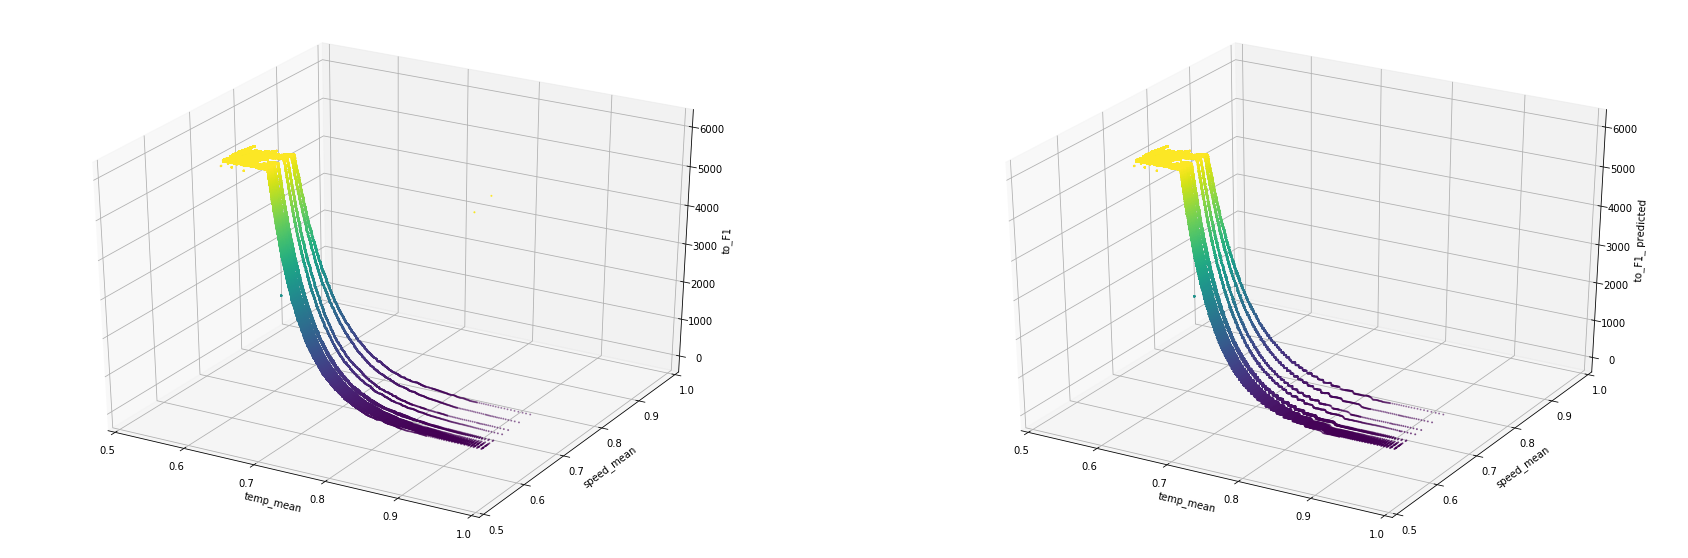

CPU times: user 29 s, sys: 1.5 s, total: 30.5 s
Wall time: 28.1 s


In [171]:
%%time
# Comparaison des prévisions pour les pannes F1.
# On ne représente que donnees_test pour des raisons de temps de calcul
# Remarquer les ondulations pour les valeurs prédites faibles (approximations en escaliers)
df = donnees_test_code[0]
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
z = df["to_F1"]
ax.scatter(xs=df["temp_mean"], ys=df["speed_mean"], zs=z, s=1, c=z)
ax.set_xlim([.5, 1])
ax.set_ylim([.5, 1])
ax.set_xlabel('temp_mean')
ax.set_ylabel('speed_mean')
ax.set_zlabel('to_F1')

ax = fig.add_subplot(1, 2, 2, projection='3d')
z = grid_search.predict(donnees_test_sans[0])
ax.scatter(xs=df["temp_mean"], ys=df["speed_mean"], zs=z, s=1, c=z)
ax.set_xlim([.5, 1])
ax.set_ylim([.5, 1])
ax.set_xlabel('temp_mean')
ax.set_ylabel('speed_mean')
ax.set_zlabel('to_F1_ predicted')
plt.tight_layout()
plt.show()

 ### Pannes de code F2

In [137]:
forest2_F2 = RandomForestRegressor(oob_score=True, verbose=3)

In [138]:
param_grid_F2 = [{"n_estimators": [10, 30, 50], "max_depth": [5, 7, 14]}]

In [139]:
grid_search_F2 = GridSearchCV(forest2_F2, param_grid_F2, cv=5, scoring="neg_mean_squared_error", return_train_score=True, refit=True, verbose=3, n_jobs=-1)

In [140]:
%%time
grid_search_F2.fit(donnees_train_sans[1], donnees_train_target[1])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 21.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.5min finished


CPU times: user 4min 35s, sys: 1.46 s, total: 4min 36s
Wall time: 25min 46s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=True, random_state=None,
                                             verbose=3, warm_start=False),
             iid='deprecated', n_job

In [360]:
cvres_F2 = grid_search_F2.cv_results_
for mean_score, params in zip(cvres_F2["mean_test_score"], cvres_F2["params"]):
    print(np.sqrt(-mean_score), "  ", params)
print("Meilleurs paramètres: ", grid_search_F2.best_params_)

27.53938219363357    {'max_depth': 5, 'n_estimators': 10}
27.478140294100204    {'max_depth': 5, 'n_estimators': 30}
27.43841733189995    {'max_depth': 5, 'n_estimators': 50}
21.056786302977464    {'max_depth': 7, 'n_estimators': 10}
21.044006582393532    {'max_depth': 7, 'n_estimators': 30}
21.03372221178776    {'max_depth': 7, 'n_estimators': 50}
25.302247588879975    {'max_depth': 14, 'n_estimators': 10}
24.94396818497095    {'max_depth': 14, 'n_estimators': 30}
24.952381395799875    {'max_depth': 14, 'n_estimators': 50}


In [169]:
print("*** Erreur-type sur l'ensemble de test pour les pannes F2: ",
      np.sqrt(mean_squared_error(donnees_test_target[1], grid_search_F2.predict(donnees_test_sans[1]))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


*** Erreur type sur l'ensemble de test pour les pannes F2:  17.802189014180158


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


In [144]:
joblib.dump(grid_search_F2, "forest2_F2_grid_search.pkl")

['forest2_F2_grid_search.pkl']

In [170]:
confidence = .95
squared_errors = (grid_search_F2.predict(donnees_test_sans[1]) - donnees_test_target[1]) ** 2
print("*** Intervalle de confiance à 95% pour l'erreur-type pour les pannes F2: ",
      np.sqrt(stats.t.interval(confidence, len(squared_errors) -1, loc = squared_errors.mean(), scale = stats.sem(squared_errors))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


*** Intervalle de confiance à 95% pour l'erreur type pour les pannes F2:  [17.66288126 17.94041507]


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


# Réseau de neurones (MLP) --- (en cours)

In [85]:
# Mélange des données d'entraînement:
donnees_train = donnees_train.sample(frac=1).reset_index(drop=True)

In [86]:
# création d'un ensemble de validation
# le nouvel ensemble d'entraînemt est réduit, donc se nomme "tra" au lieu de "train"
donnees_tra, donnees_valid = split_train_test(donnees_train, mac_panne, test_ratio=0.15, seed=10)

Nombre de machines en test (sur 851 machines): 131.


In [87]:
donnees_tra_code = donnees_par_code(donnees_tra)
donnees_valid_code = donnees_par_code(donnees_valid)

donnees_tra_sans, donnees_tra_target = separe_target(donnees_tra_code)
donnees_valid_sans, donnees_valid_target = separe_target(donnees_valid_code)

In [88]:
mlp = keras.models.Sequential([
    keras.layers.Dense(10, input_dim=3, activation="elu", kernel_initializer="he_normal"),
#    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="elu", kernel_initializer="he_normal"),
#    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="relu"),
])

In [89]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [90]:
mlp.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, clipvalue=1))

In [398]:
%%time
# Pour la panne F1
history_F1 = mlp.fit(donnees_tra_sans[0][:100_000].values, donnees_tra_target[0][:100_000].values, epochs=3, batch_size=32, validation_data=(donnees_valid_sans[0].values, donnees_valid_target[0].values))

Train on 100000 samples, validate on 631826 samples
Epoch 1/3
100000/100000 [==============================] - 19s 194us/sample - loss: 31216002.4493 - val_loss: 30568589.9111
Epoch 2/3
100000/100000 [==============================] - 21s 213us/sample - loss: 31216002.4205 - val_loss: 30568589.9111
Epoch 3/3
100000/100000 [==============================] - 22s 221us/sample - loss: 31216002.4762 - val_loss: 30568589.9111
CPU times: user 1min 27s, sys: 6.11 s, total: 1min 33s
Wall time: 1min 2s


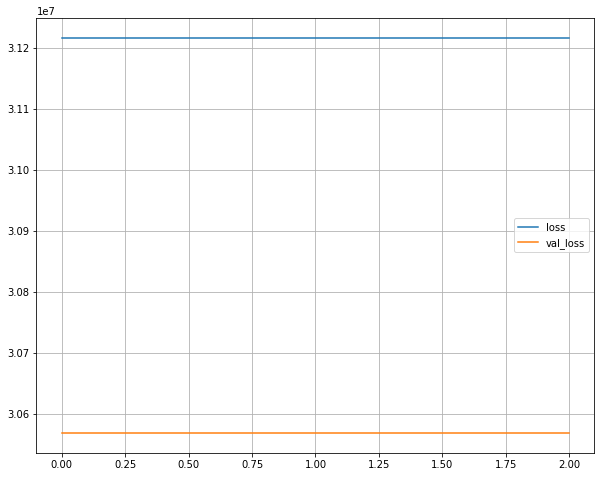

In [379]:
pd.DataFrame(history_F1.history).plot(figsize=(10,8))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

In [68]:
%%time
# Pour la panne F2
history_F2 = mlp.fit(donnees_tra_sans[1].values, donnees_tra_target[1].values, epochs=3, batch_size=32, validation_data=(donnees_valid_sans[1].values, donnees_valid_target[1].values))

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


In [381]:
mlp.layers

In [382]:
mlp.layers[0].get_weights()

[array([[ 0.34114924,  0.3169033 , -0.90097624, -0.89657754,  0.24671125,
          0.9024429 ,  1.1659285 , -0.22600141,  1.4780886 , -0.31399888,
          0.8686358 , -0.8861315 ,  1.1700939 , -1.3837148 , -0.6198169 ,
         -0.8820854 , -0.24861206, -0.28246558, -0.32166865,  0.04486593,
          1.3574743 , -0.40147123,  0.6161963 , -0.16424802, -0.03546874,
          0.31585404, -0.1467059 ,  1.3755726 , -0.57697433,  1.2088324 ],
        [ 1.247694  , -1.1737167 ,  0.9199097 , -0.14371584, -0.35047746,
          0.66311985,  0.59766036, -0.32749876,  0.229429  , -1.120034  ,
          0.1682288 ,  0.9224916 ,  0.47528696, -0.54972965, -1.0824568 ,
          0.7201568 , -0.14874454, -1.3619338 ,  0.6820042 , -1.6841877 ,
          0.03583505,  0.96621823,  0.30239758,  0.9035513 , -0.04050218,
         -1.0078877 , -1.0012734 , -0.78292817,  0.58671427,  0.8321497 ],
        [-1.7517358 ,  1.3098285 ,  0.60809684,  0.44230473,  1.3386161 ,
          0.02740737,  0.35102546,  

In [383]:
mlp.layers[0].get_weights()[0].shape

(3, 30)

In [384]:
mlp.layers[0].get_weights()[1].shape

(30,)